In [121]:
utf8::utf8_print('\U0001f6a7 work in progress \U0001f6a7')

[1] "🚧​ work in progress 🚧​"


# Study of the synonymous mutations

Created: **19/07/18**  
Last modified: **09/08/18**

**Goal:** this study will focus only on the `synonymous_SNV` mutations, trying first to filter the non-somatic synonymous mutations and then to study the reccurent synonymous mutations. This notebook follows the methodology of the `coding_mutations_analysis.ipynb` notebook.  
This notebook is divided in two parts:
* **1. The `label` feature: coding_somatic vs synonymous**: introduce a new feature to class the mutations as coding_somatic or synonymous. The idea is to filter the set of synonymous mutations by comparing their parameters to a set of known somatic mutations parameters.
* **2. The `mut_key` feature: study of reccurent mutations**: study the reccurence of synonymous mutations.

**Refs:**
* `coding_mutations_analysis.ipynb`

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#The-label-feature:-coding_somatic-vs-synonymous" data-toc-modified-id="The-label-feature:-coding_somatic-vs-synonymous-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>The <code>label</code> feature: coding_somatic vs synonymous</a></span><ul class="toc-item"><li><span><a href="#Creating-the-feature" data-toc-modified-id="Creating-the-feature-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Creating the feature</a></span></li><li><span><a href="#Comparison-of-the-frequency_in_normals,-t_vaf-and-strand_ratio" data-toc-modified-id="Comparison-of-the-frequency_in_normals,-t_vaf-and-strand_ratio-1.2"><span class="toc-item-num">1.2&nbsp;&nbsp;</span>Comparison of the <code>frequency_in_normals</code>, <code>t_vaf</code> and <code>strand_ratio</code></a></span></li><li><span><a href="#Comparison-of-Kaviar_AF" data-toc-modified-id="Comparison-of-Kaviar_AF-1.3"><span class="toc-item-num">1.3&nbsp;&nbsp;</span>Comparison of <code>Kaviar_AF</code></a></span></li><li><span><a href="#Comparison-of-cosmic_count" data-toc-modified-id="Comparison-of-cosmic_count-1.4"><span class="toc-item-num">1.4&nbsp;&nbsp;</span>Comparison of <code>cosmic_count</code></a></span></li></ul></li><li><span><a href="#The-mut_key-feature:-study-of-reccurent-mutations" data-toc-modified-id="The-mut_key-feature:-study-of-reccurent-mutations-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>The <code>mut_key</code> feature: study of reccurent mutations</a></span><ul class="toc-item"><li><span><a href="#Identify-the-reccurent-mutations" data-toc-modified-id="Identify-the-reccurent-mutations-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Identify the reccurent mutations</a></span></li><li><span><a href="#Sudy-the-reccurent-mutations-genes" data-toc-modified-id="Sudy-the-reccurent-mutations-genes-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Sudy the reccurent mutations genes</a></span></li><li><span><a href="#Study-the-outliers" data-toc-modified-id="Study-the-outliers-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Study the outliers</a></span></li></ul></li></ul></div>

***

In [286]:
source("../../../src/utils/custom_tools.R")
setup_environment("../../../src/utils")

In [292]:
impact <- read.table("../../../data/cleaned_IMPACT_mutations_180508.txt", sep = "\t", stringsAsFactors = FALSE, header = TRUE)
impact <- add_features("../../../data/", impact, annotations = TRUE)

In [293]:
colnames(impact)

[1] "Hugo_Symbol"          "Chromosome"           "Start_Position"      
 [4] "End_Position"         "Consequence"          "Variant_Type"        
 [7] "Reference_Allele"     "Tumor_Seq_Allele2"    "Tumor_Sample_Barcode"
[10] "cDNA_change"          "HGVSp_Short"          "t_depth"             
[13] "t_vaf"                "t_alt_count"          "n_depth"             
[16] "n_vaf"                "n_alt_count"          "t_ref_plus_count"    
[19] "t_ref_neg_count"      "t_alt_plus_count"     "t_alt_neg_count"     
[22] "confidence_class"     "sample_coverage"      "mut_key"             
[25] "sample_mut_key"       "frequency_in_normals" "Kaviar_AF"           
[28] "cosmic_count"

## The `label` feature: coding_somatic vs synonymous

The `synonymous_SNV` mutations have automatically been classified as `UNKNOWN` so we don't know which one are somatic or non-somatic mutations. However, the coding mutations have been curated, and we know which one of them are somatic. Thus, we can take the somatic coding mutations as a reference of mutations that are somatic. For example, comparing the `frequency_in_normals` for `synonymous_SNV` mutations and somatic coding mutations could reveal a difference and help us to filter the `synonymous_SNV` mutations that are somatic from the one that are non-somatic.  

Unfortunately, this study will show that the `frequency_in_normals`, `t_vaf` and `strand_bias` features won't be relevant to filter the `synonymous_SNV` mutations. However, the `Kaviar_AF` feature could help us!

### Creating the feature

We create a new feature `label`:
* A mutation has `label = synonymous` if `Consequence = synonymous_SNV`
* A mutation has `label = coding_somatic` if it is a coding mutation and `confidence_class = AUTO_OK | MANUAL_OK`.

In [294]:
impact <- impact[(impact$Consequence == "synonymous_SNV") |
                 (impact$Consequence != "synonymous_SNV" & (impact$confidence_class == "AUTO_OK" |
                                                            impact$confidence_class == "MANUAL_OK")),]
impact$label <- "coding_somatic"
impact$label[(impact$Consequence == "synonymous_SNV")] <- "synonymous"

addmargins(table(impact$label, impact$confidence_class), margin = 2)
100 * nrow(impact[impact$label == "synonymous",]) / nrow(impact) # percentage of synonymous mutations

AUTO_OK MANUAL_OK UNKNOWN Sum   
  coding_somatic 180733  6335          0   187068
  synonymous          0     0      50005    50005

[1] 21.09266

The dataset is unbalanced with 50,010 synonymous mutations ($21.1\%$ of the samples) vs 187,098 somatic mutations ($78.9\%$ of the samples).

### Comparison of the `frequency_in_normals`, `t_vaf` and `strand_ratio`

We create the `strand_ratio` feature:

In [295]:
impact$strand_ratio <- pmin(impact$t_alt_neg_count, impact$t_alt_plus_count) /
                       pmax(impact$t_alt_neg_count, impact$t_alt_plus_count)

Distribution of `frequency_in_normals`, `tvaf` and `strand_ratio` for the coding vs synonymous `label` (warning the first and last plot have a sqrt x and sqrt y scale):

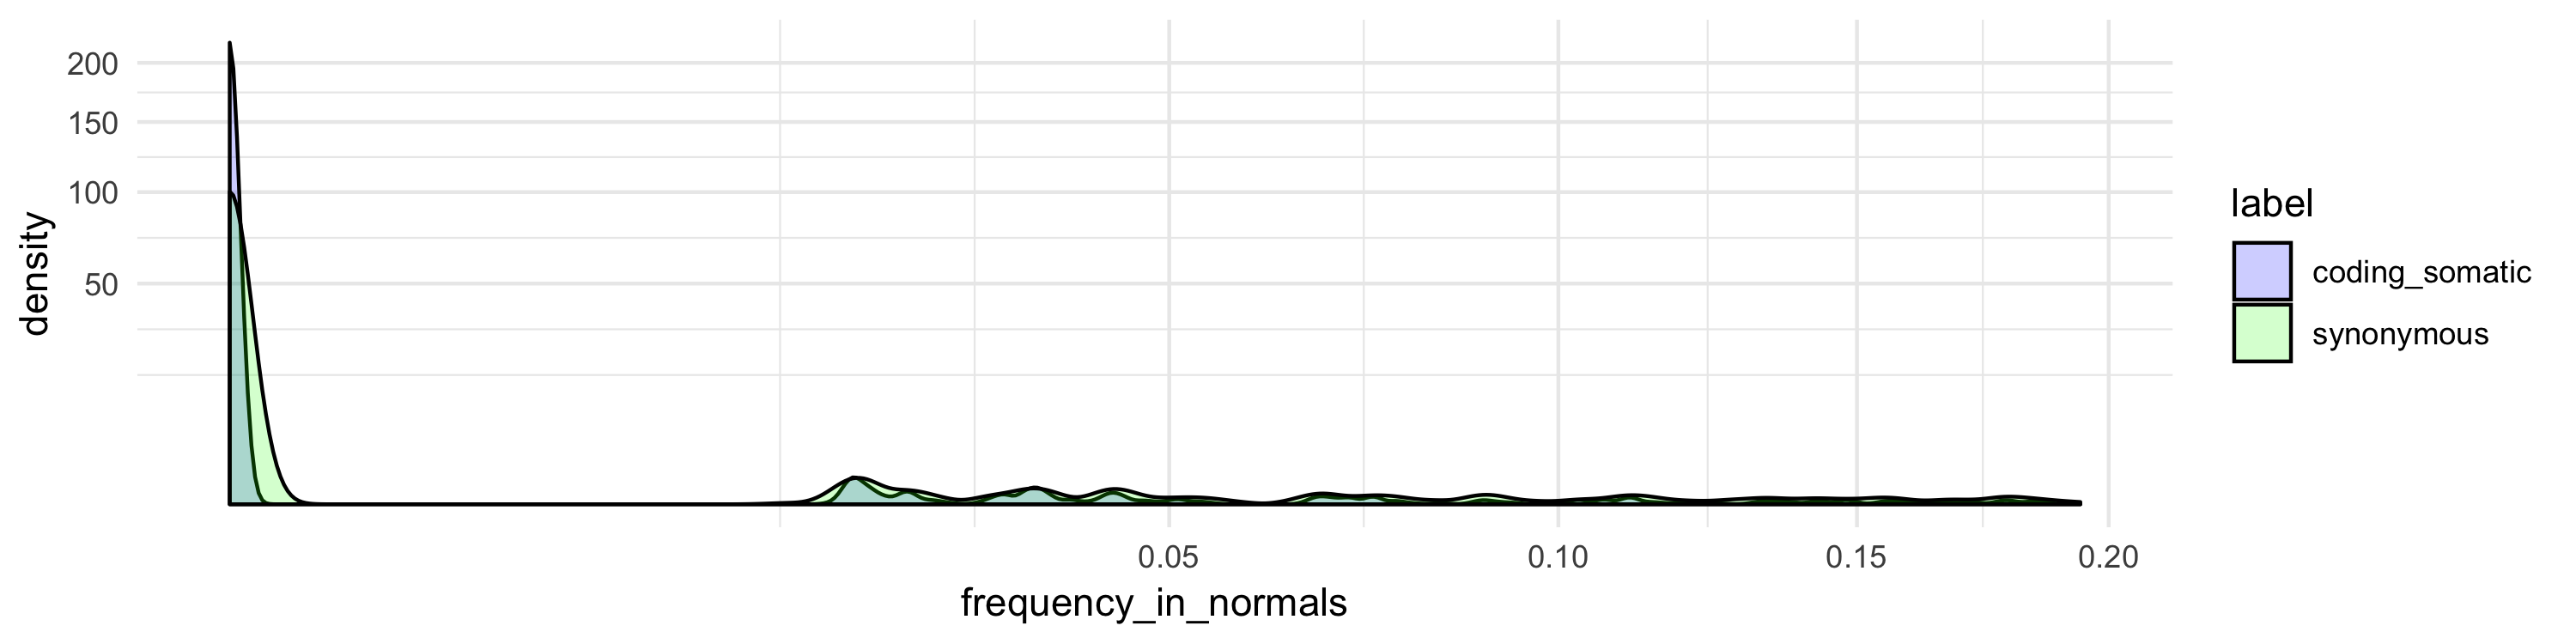

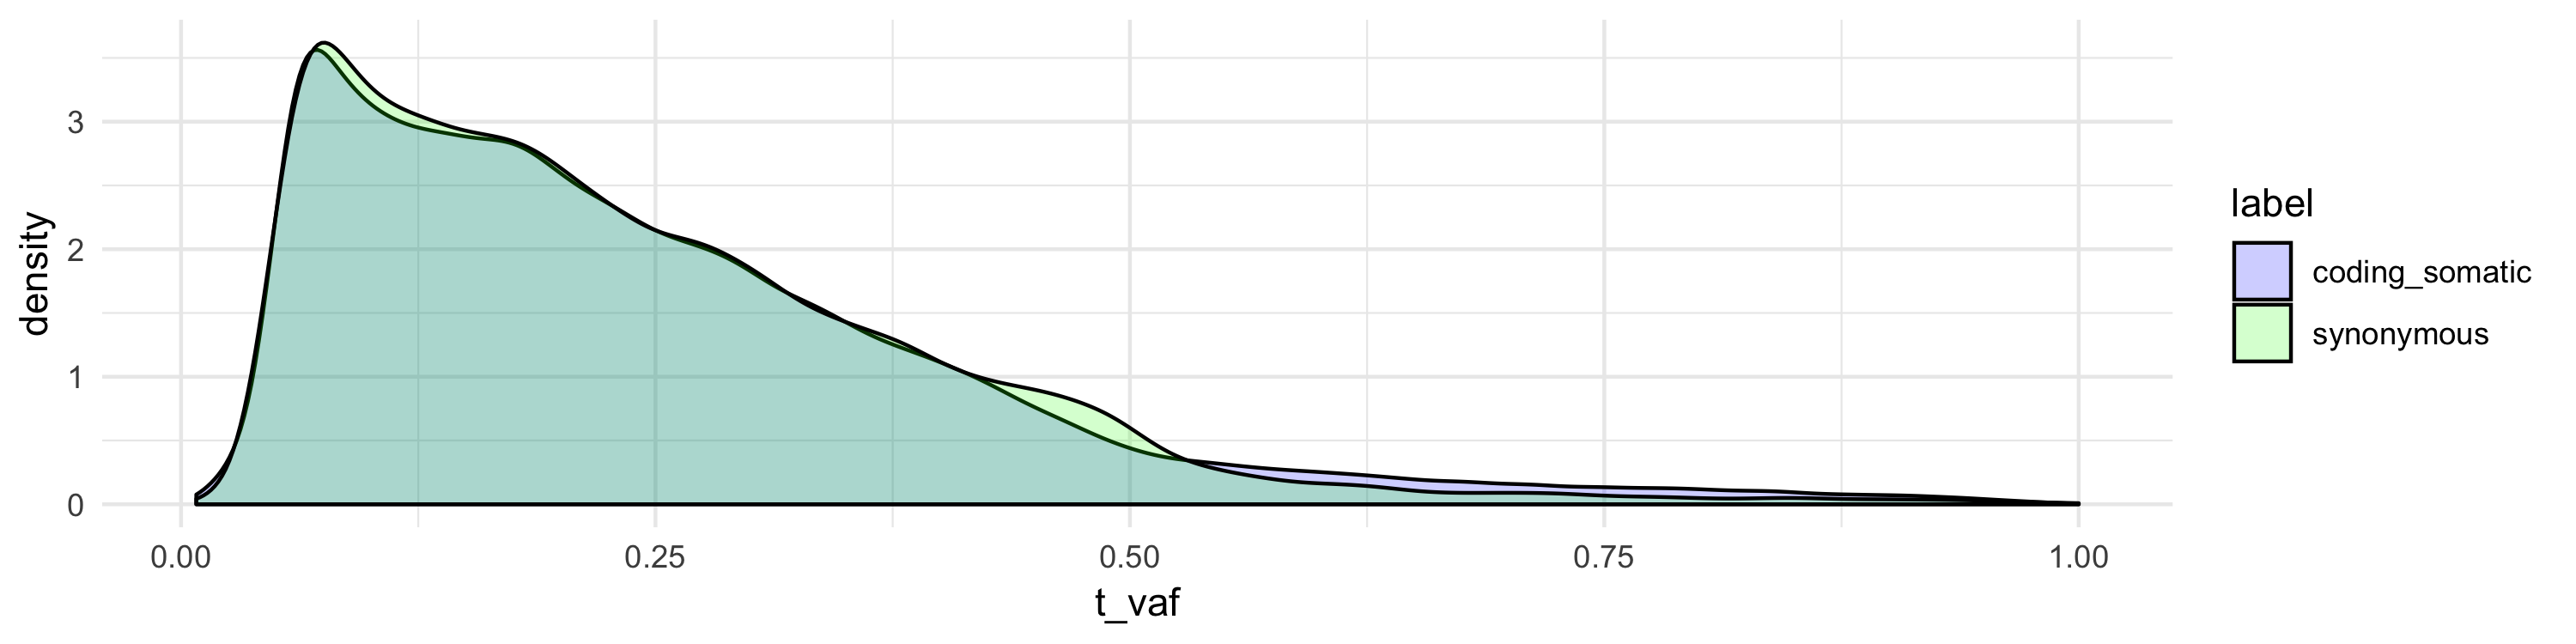

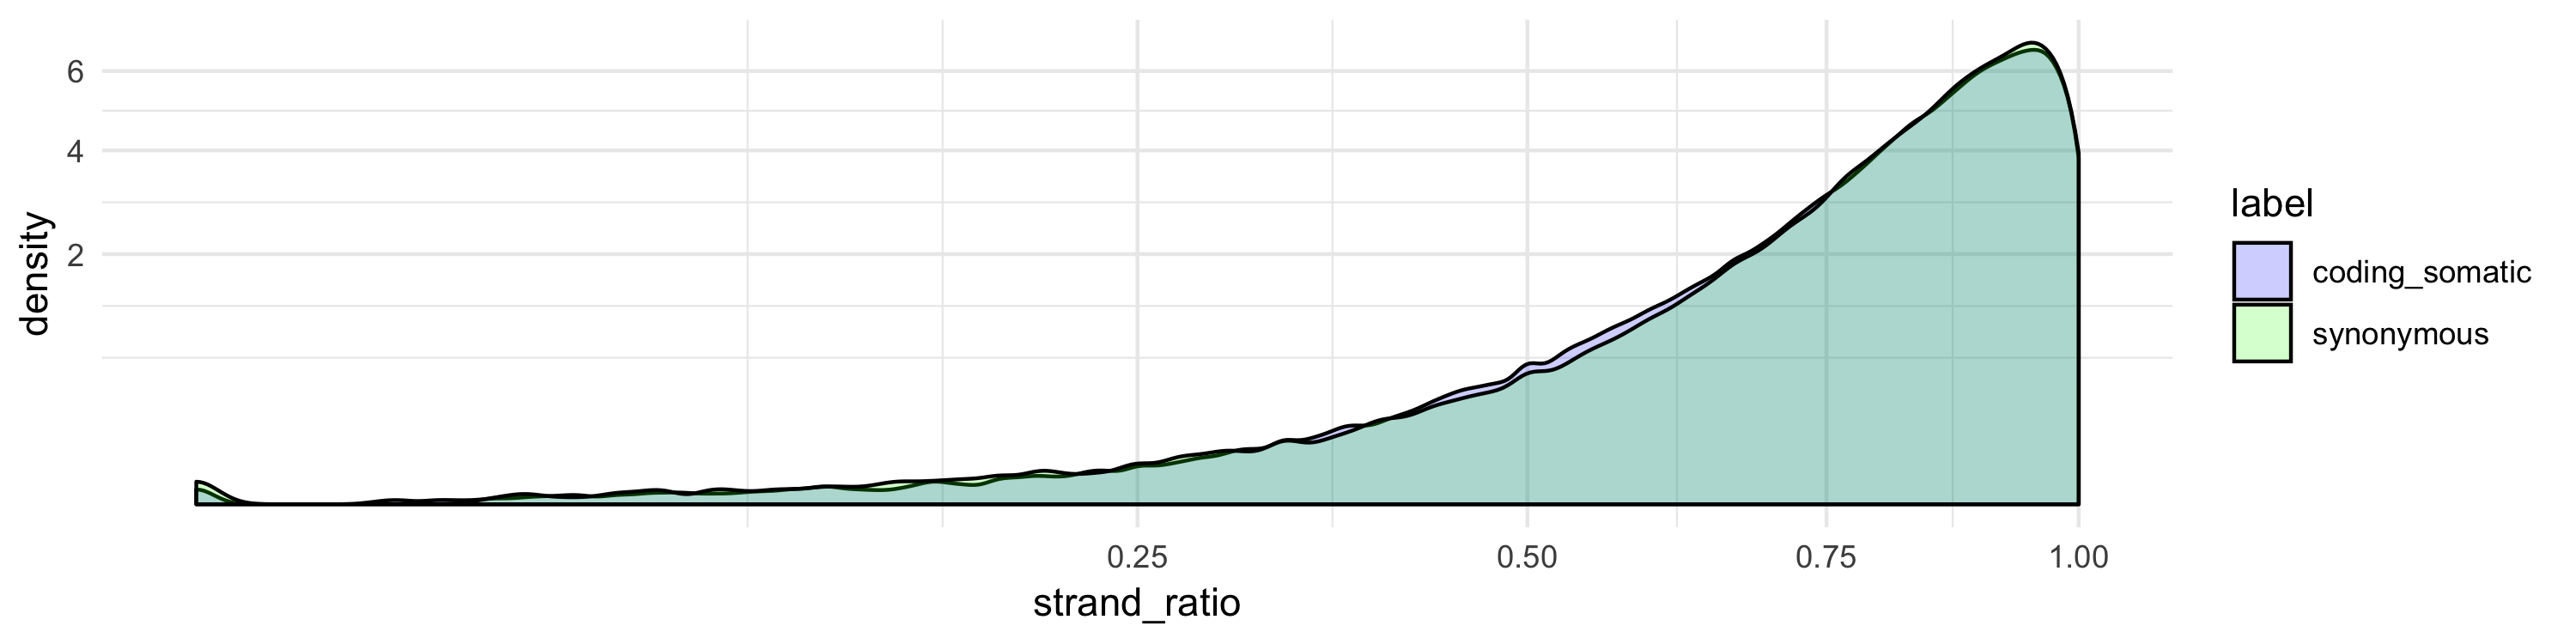

In [296]:
plot_density(impact, "frequency_in_normals", "label", height = 2.5) + scale_x_sqrt() + scale_y_sqrt()
plot_density(impact, "t_vaf", "label", height = 2.5)
plot_density(impact, "strand_ratio", "label", height = 2.5) + scale_x_sqrt() + scale_y_sqrt()

The distributions are almost identical in every plot. Wee see a little bump at `t_vaf` $\approx 0.5$ for the synonymous mutations, most likely the germline part of it but it is really not pronounced.

Below is an attempt to plot the `strand_ratio` vs the `t_vaf` to separate the germline (`t_vaf` $\approx 0.5$ and high `strand_ratio`) from the artefact (low `t_vaf` and low `strand_ratio`), but nothing really discriminant was found.

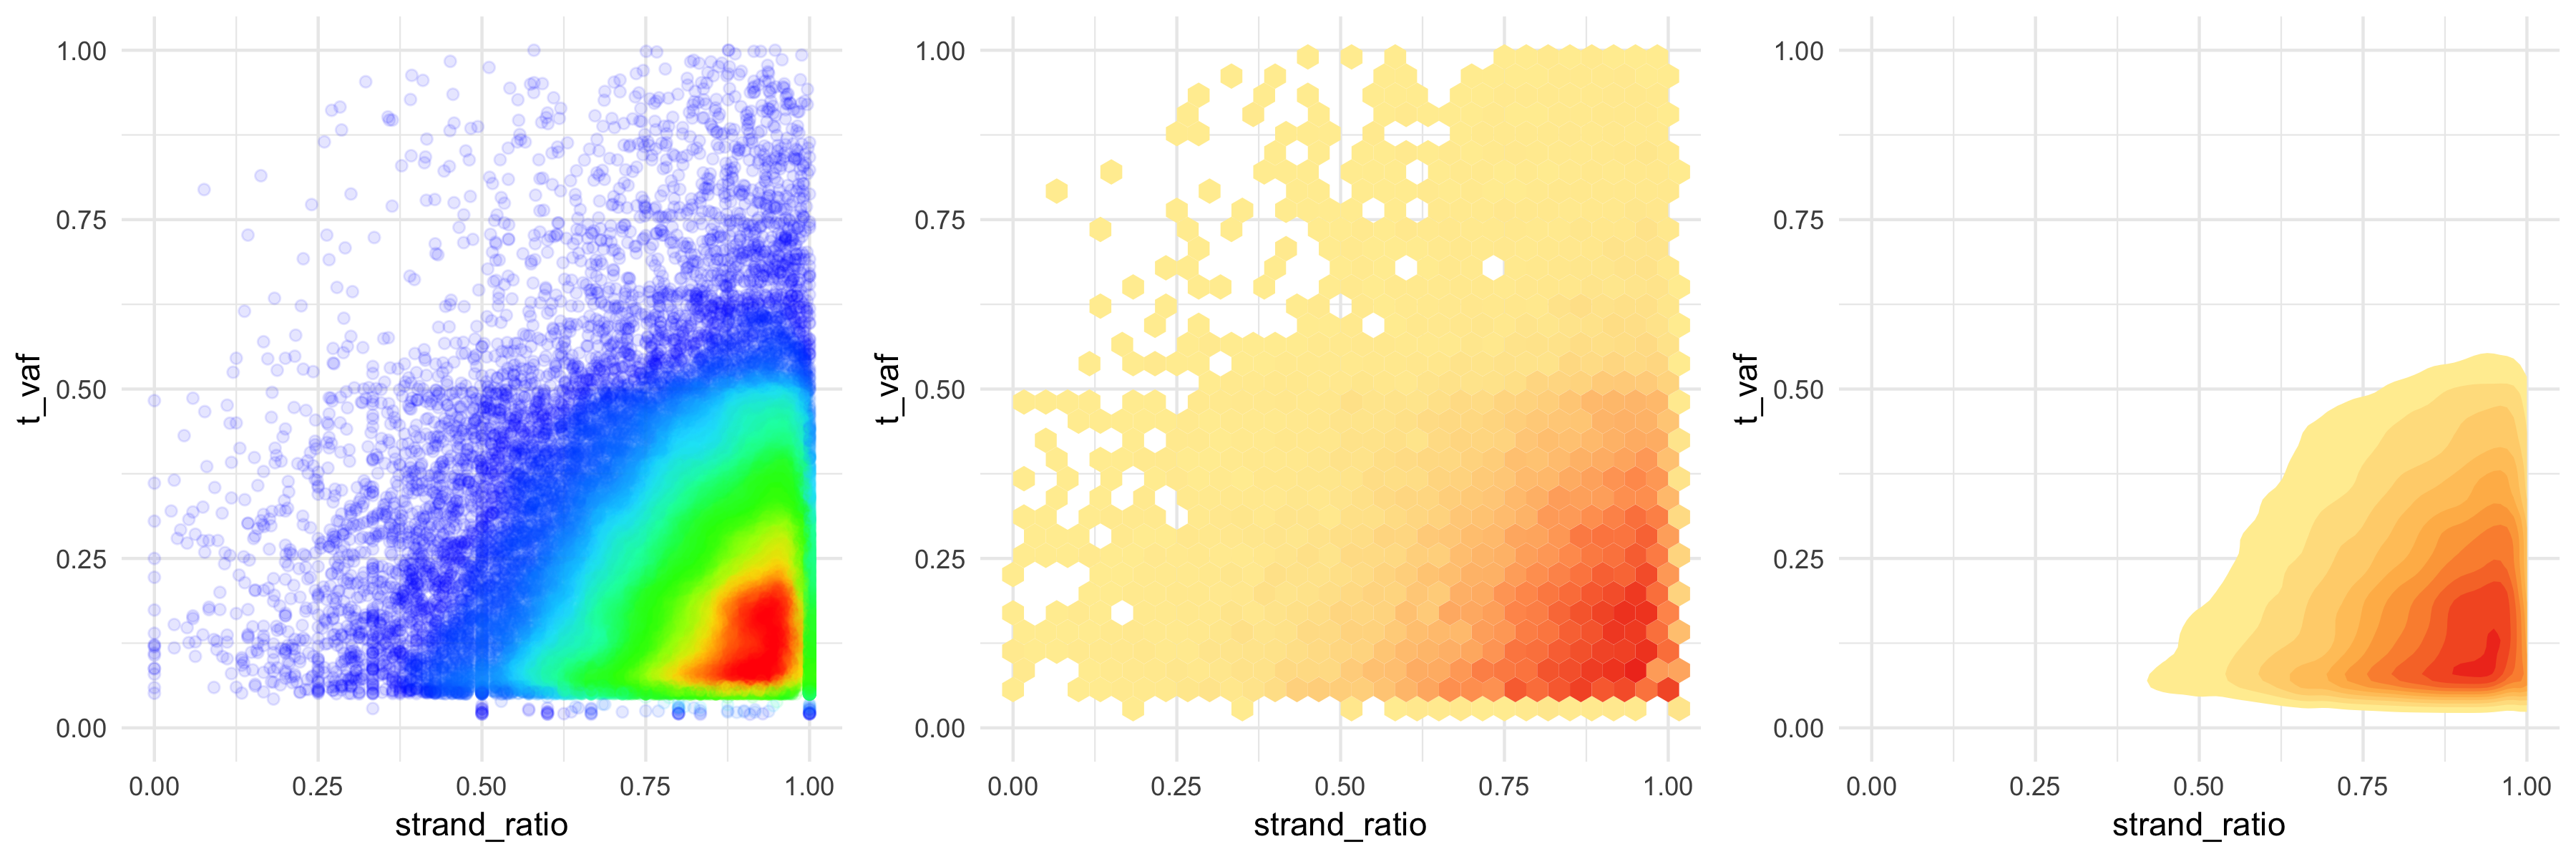

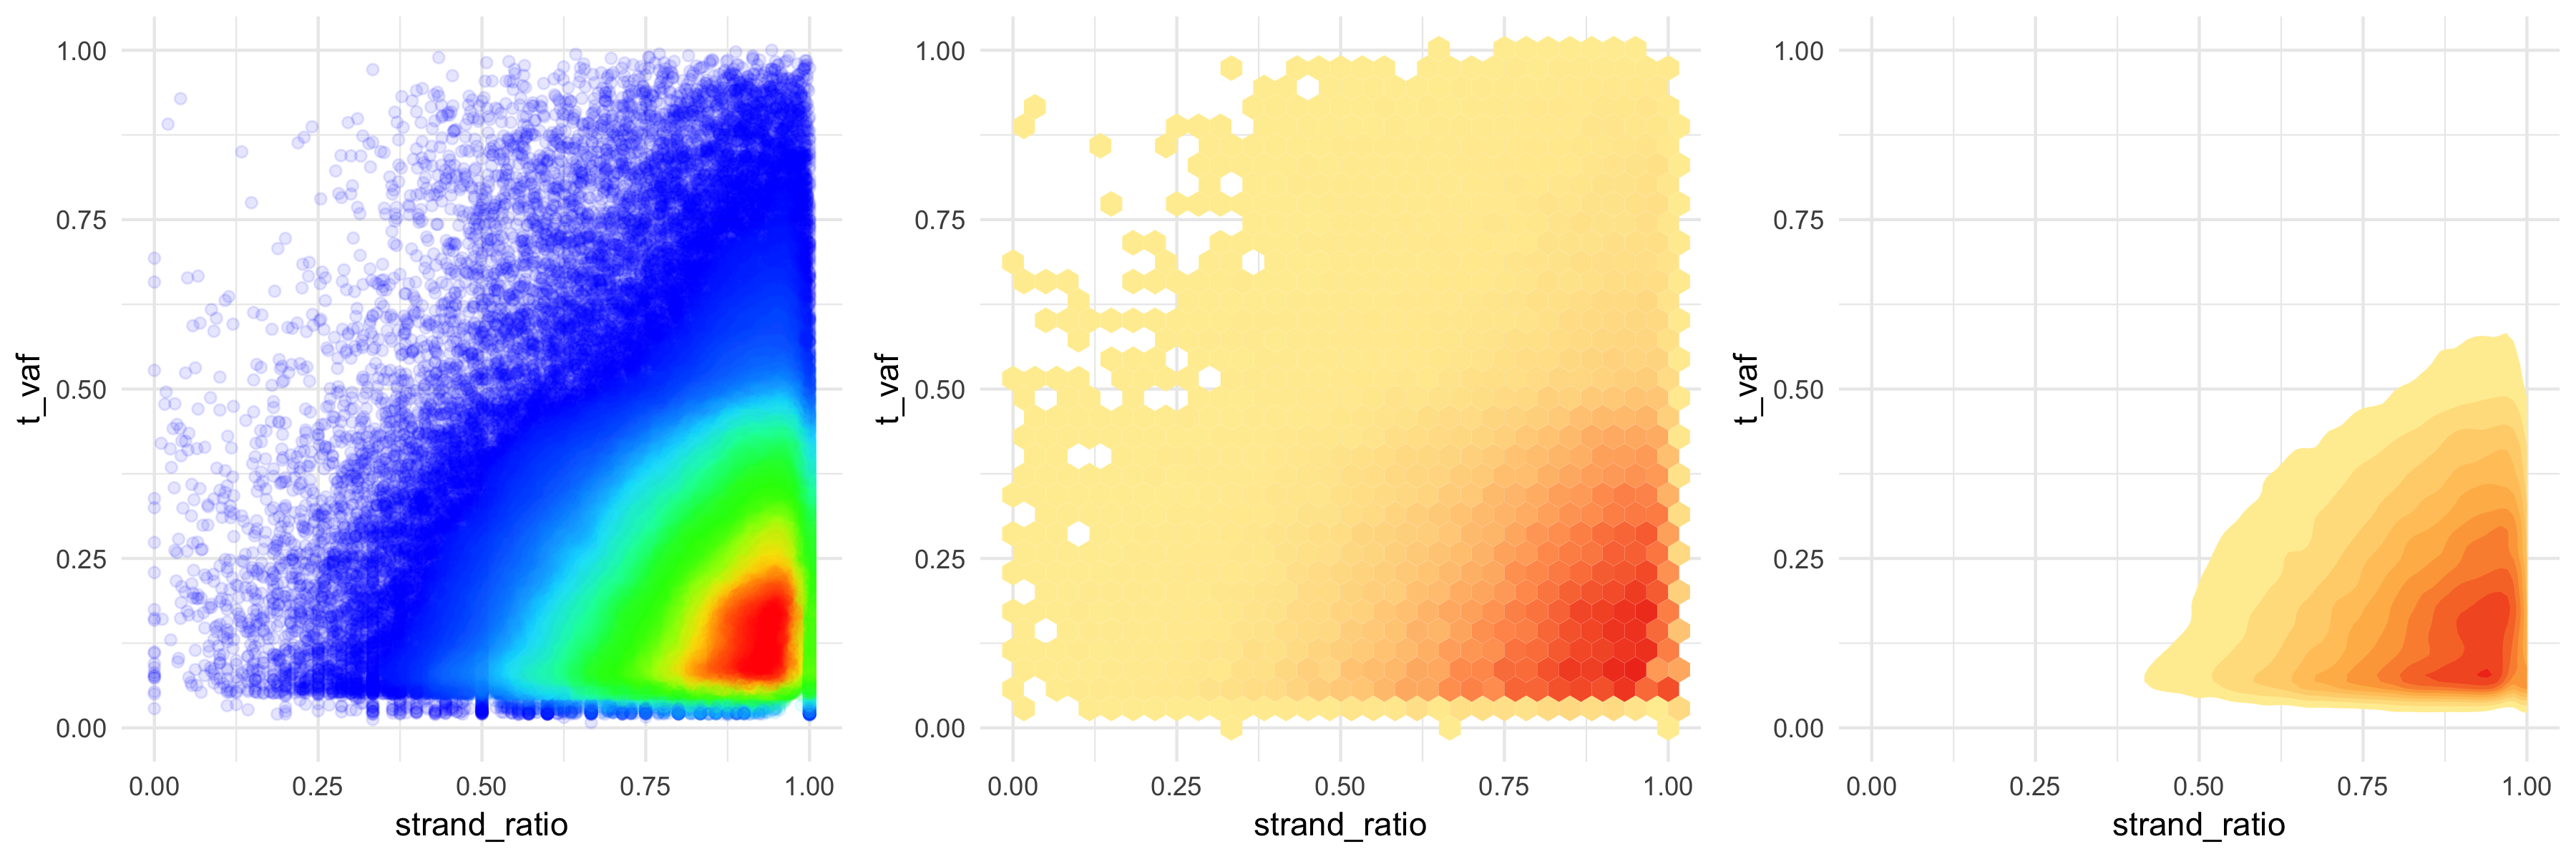

In [297]:
plot_density_2d(impact[impact$label == "synonymous",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))
plot_density_2d(impact[impact$label == "coding_somatic",], "strand_ratio", "t_vaf",
                to_add = coord_cartesian(xlim = c(0,1), ylim = c(0,1)))

### Comparison of `Kaviar_AF`

Distribution of `Kaviar_AF` for the coding vs synonymous `label` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `Kaviar_AF` ie 26.64% of the data):

[1] "63157 over 237073 (26.64%)"

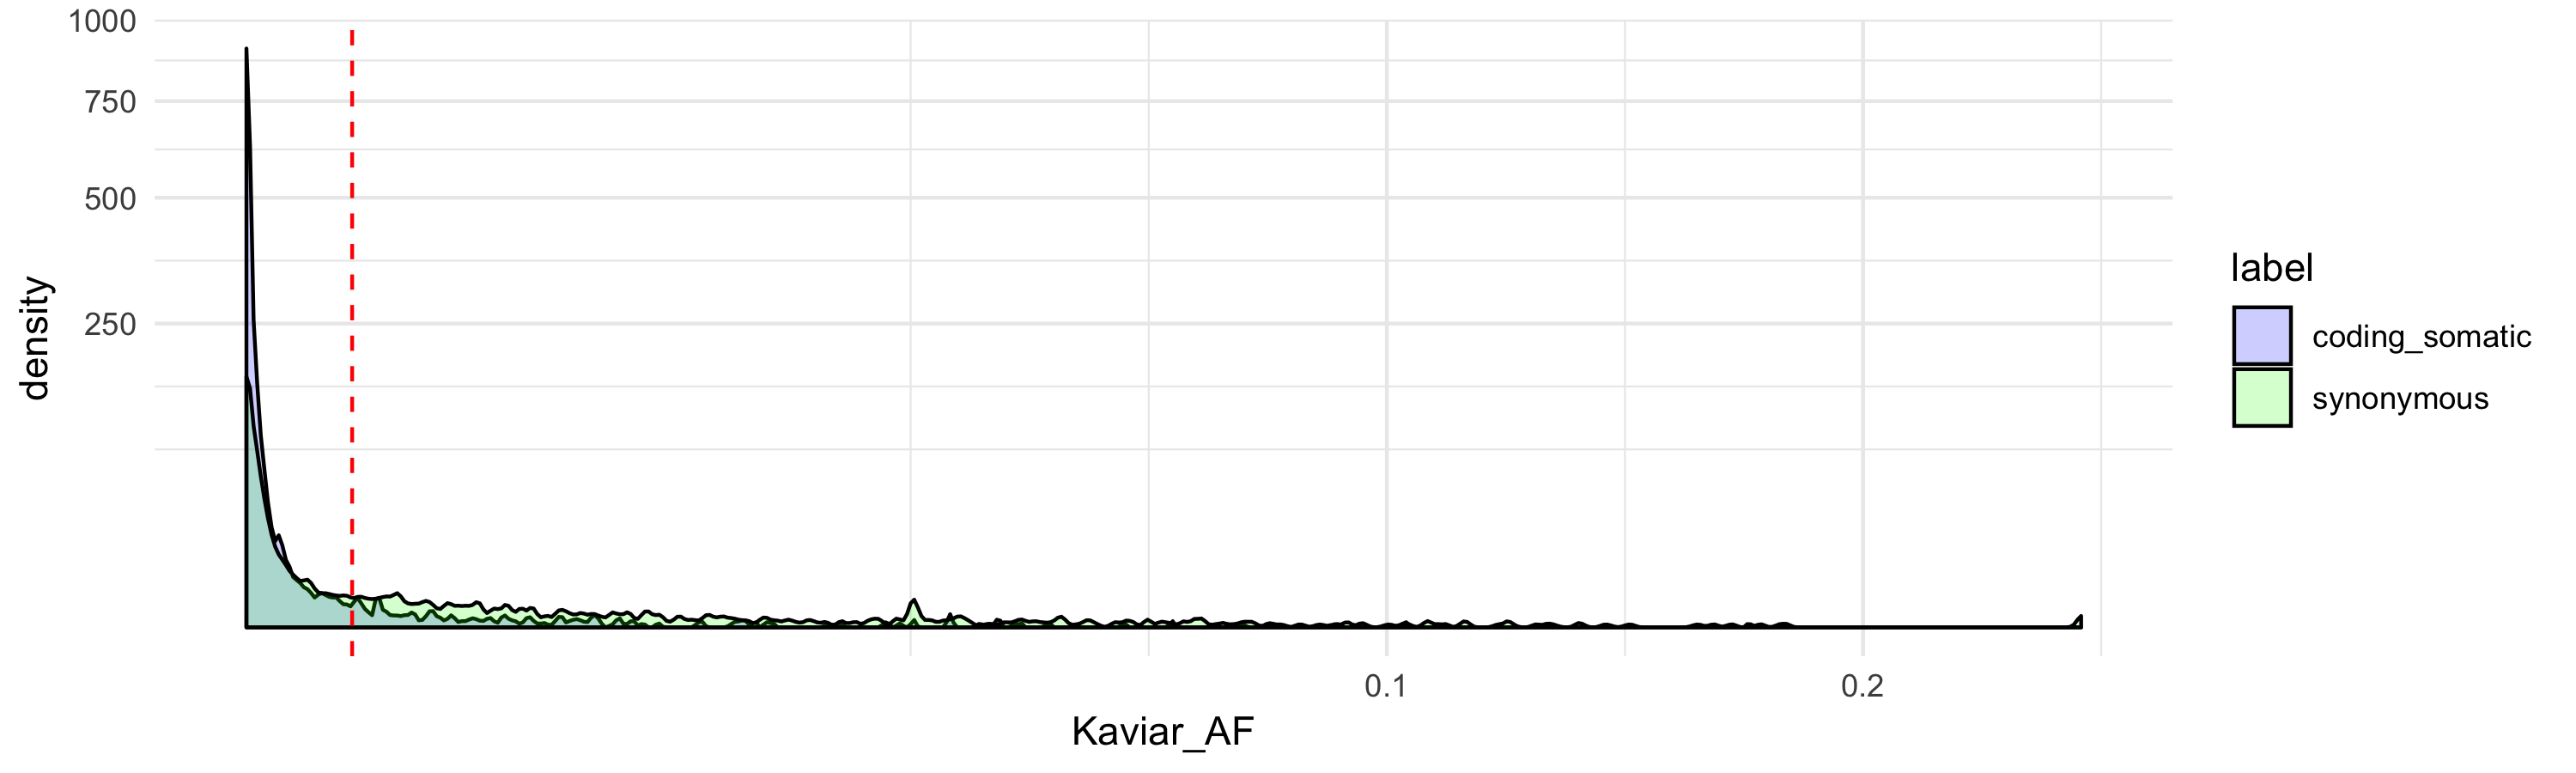

In [298]:
print_count_and_proportion(impact[impact$Kaviar_AF != 0,], impact)
plot_density(impact[impact$Kaviar_AF != 0,], "Kaviar_AF", "label", lines = 0.001) + scale_x_sqrt() + scale_y_sqrt()

The synonymous mutations present a heavier `Kaviar_AF` tail, which are likely to be the artefacts call.

In [299]:
summary(impact[impact$label == "coding_somatic",]$Kaviar_AF)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.000e+00 0.000e+00 0.000e+00 2.594e-05 0.000e+00 1.730e-01 

In [300]:
summary(impact[impact$label == "synonymous",]$Kaviar_AF)

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
0.0000000 0.0000000 0.0000000 0.0005997 0.0000065 0.2572410 

In [301]:
100 * nrow(impact[impact$label == "coding_somatic" &
                  impact$Kaviar_AF > 0.001,]) / nrow(impact[impact$label == "coding_somatic",])
100 * nrow(impact[impact$label == "synonymous" &
                  impact$Kaviar_AF > 0.001,]) / nrow(impact[impact$label == "synonymous",])

[1] 0.2747664

[1] 4.173583

We are going to set a threshold on the `Kaviar_AF` parameter to try to curate the `synonymous` mutations, even if the threshold is a bit severe and will loose some somatic synonymous, we should still be able to work on a sufficient amount of `synonymous` mutations. The threshold will be set at 0.001 (see red line on the plot above).

In [302]:
impact <- impact[impact$label != "synonymous" |
                 (impact$label == "synonymous" & impact$Kaviar_AF <= 0.001),]

### Comparison of `cosmic_count`

Distribution of `cosmic_count` for the coding vs synonymous `albel` (warning this is a sqrt x and sqrt y scale and this plot concerns only the non-null `cosmic_count` ie 21,88% of the data):

[1] "51598 over 234986 (21.96%)"

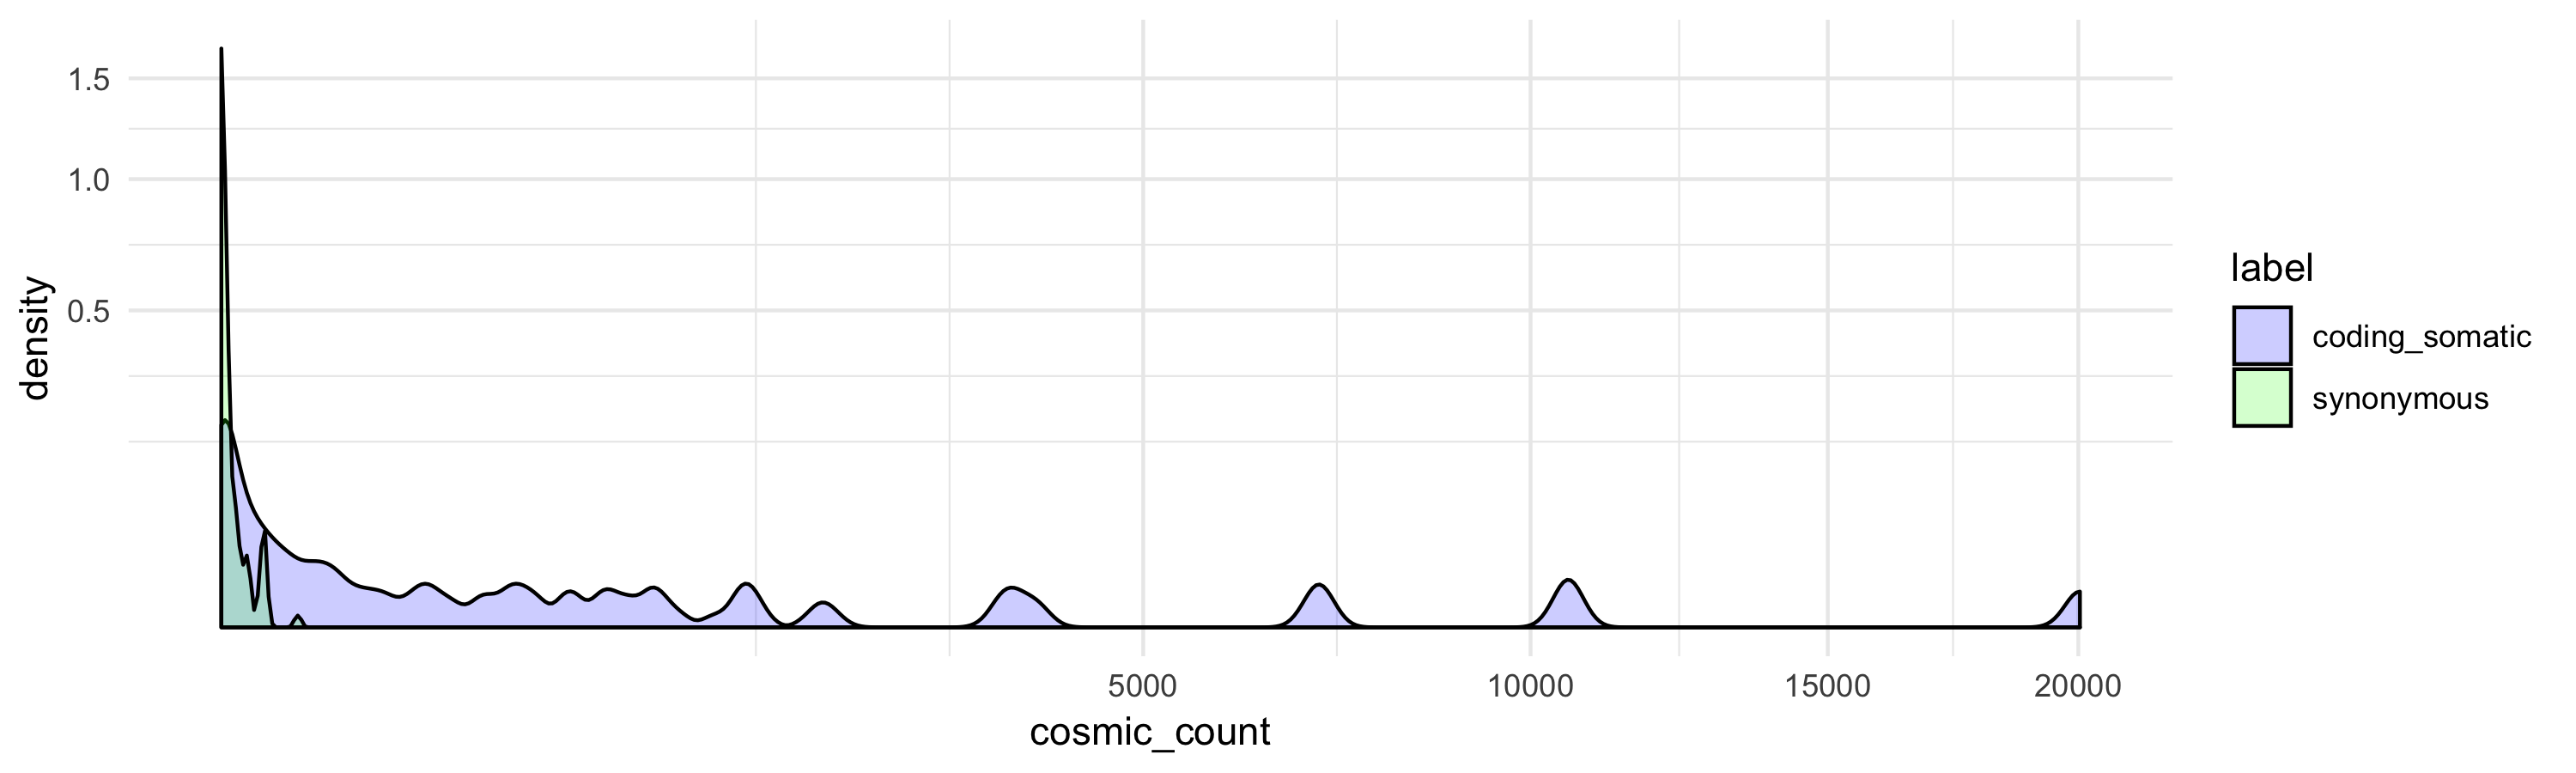

In [303]:
print_count_and_proportion(impact[impact$cosmic_count != 0,], impact)
plot_density(impact[impact$cosmic_count != 0,], "cosmic_count", "label") + scale_x_sqrt() + scale_y_sqrt()

As expected the `synonymous` mutations have a really low `cosmic_count`.

In [304]:
summary(impact[impact$label == "synonymous",]$cosmic_count)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.0000  0.0000  0.0000  0.1262  0.0000 46.0000 

However, some of the synonymous mutations have an unexpectedly high `cosmic_count`:

In [305]:
impact[impact$label == "synonymous",] %>% group_by(mut_key) %>%
                                          filter(cosmic_count > 10) %>%
                                          summarise(cosmic_count = unique(cosmic_count),
                                                    Hugo_Symbol = unique(Hugo_Symbol),
                                                    HGVSp_Short = unique(HGVSp_Short),
                                                    frequency_in_normals = mean(frequency_in_normals),
                                                    Kaviar_AF = unique(Kaviar_AF)) %>%
                                          arrange(-cosmic_count)

mut_key         cosmic_count Hugo_Symbol HGVSp_Short frequency_in_normals
1 22_29091841_G_A 46           CHEK2       p.S372S     0                   
2 17_7579312_C_T  18           TP53        p.T125T     0                   
3 17_7579312_C_A  17           TP53        p.T125T     0                   
  Kaviar_AF
1 6.5e-06  
2 6.5e-06  
3 6.5e-06

* CHEK2 (`22_29091841_G_A`) has been [removed from COSMIC](https://cancer.sanger.ac.uk/cosmic/gene/analysis?all_data=&coords=AA%3AAA&dr=&gd=&id=407&ln=CHEK2&res_type=AA&seqlen=544&export=html&start=360&end=384)
* We will study the two TP53 mutations later

## The `mut_key` feature: study of reccurent mutations

In [306]:
impact_syn <- impact[impact$label == "synonymous",] # keep only the synonymous mutations

Each mutations is identified by a unique key `mut_key` : `Chromosome`_`Start_Position`_`Reference_Allele`_`Tumor_Seq_Allele2`. The mutations sharing the same key are the same.

In [307]:
head(impact_syn$mut_key)
length(unique(impact_syn$mut_key)) # number of different keys e.g. number of different mutations

[1] "1_27101572_C_G"  "19_5244030_C_G"  "1_162740271_C_T" "3_134977903_C_T"
[5] "X_123197875_C_A" "3_189612072_C_T"

[1] 38966

### Identify the reccurent mutations

We need to study the reccurence of mutations taking care not to consider a mutation as recurrent if it comes frome the same patient. To do so we will group the rows by patient, and select only the distinct mutations for each patient:

In [308]:
# create a patient id (no problem will be caused by 'None-T01-IM6' which will become 'None-T01-')
impact_syn$patient_id <- substr(impact_syn$Tumor_Sample_Barcode, 1, 9)
head(unique(impact_syn$patient_id))

[1] "P-0000012" "P-0000026" "P-0000027" "P-0000030" "P-0000039" "P-0000037"

In [309]:
impact_unique_mut_keys_per_patient <- as.data.frame(impact_syn %>% group_by(patient_id) %>%
                                                                   select(patient_id, mut_key, Hugo_Symbol) %>%
                                                                   filter(! duplicated(mut_key)))
nrow(impact_syn)
nrow(impact_unique_mut_keys_per_patient)

[1] 47918

[1] 46271

In [310]:
mut_key_info <- as.data.frame(impact_unique_mut_keys_per_patient %>% group_by(mut_key) %>%
                                                                     summarise(count = n(),
                                                                               Hugo_Symbol = unique(Hugo_Symbol)))
head(mut_key_info)

mut_key        count Hugo_Symbol
1 1_11168249_G_A 1     MTOR       
2 1_11168276_C_G 1     MTOR       
3 1_11168276_C_T 1     MTOR       
4 1_11168327_A_G 1     MTOR       
5 1_11168339_C_T 1     MTOR       
6 1_11169351_G_A 1     MTOR

In [311]:
for (threshold in c(2, 3, 5, 10)) {
    
    mut_key_info_threshold <- mut_key_info[mut_key_info$count >= threshold,]
    
    print(sprintf("%2.0f%% (%5d) of the keys are shared by at least %2d samples [%2.0f%% (%5d) of the rows concerned]",
                  100 * nrow(mut_key_info_threshold) / nrow(mut_key_info),
                  nrow(mut_key_info_threshold),
                  threshold,
                  100 * nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,]) / nrow(impact_unique_mut_keys_per_patient),
                  nrow(impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% mut_key_info_threshold$mut_key,])))
}

[1] "13% ( 4919) of the keys are shared by at least  2 samples [26% (12224) of the rows concerned]"
[1] " 3% ( 1226) of the keys are shared by at least  3 samples [10% ( 4838) of the rows concerned]"
[1] " 1% (  198) of the keys are shared by at least  5 samples [ 3% ( 1535) of the rows concerned]"
[1] " 0% (   32) of the keys are shared by at least 10 samples [ 1% (  568) of the rows concerned]"


Distribution of the mutations key count for the mutations present in at least 2 samples (warning this is a sqrt x and y scale):

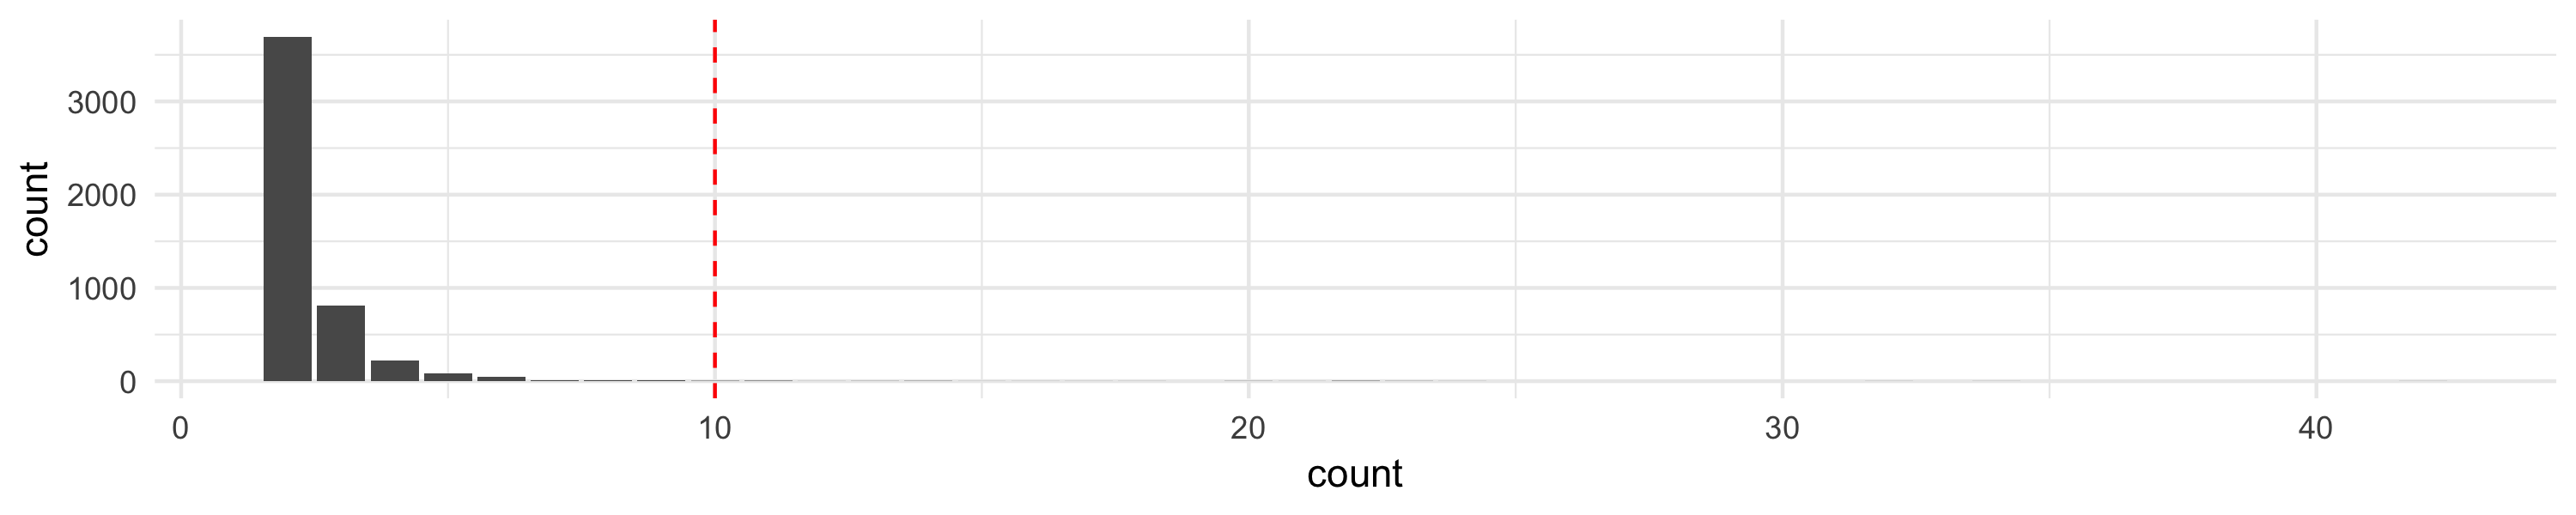

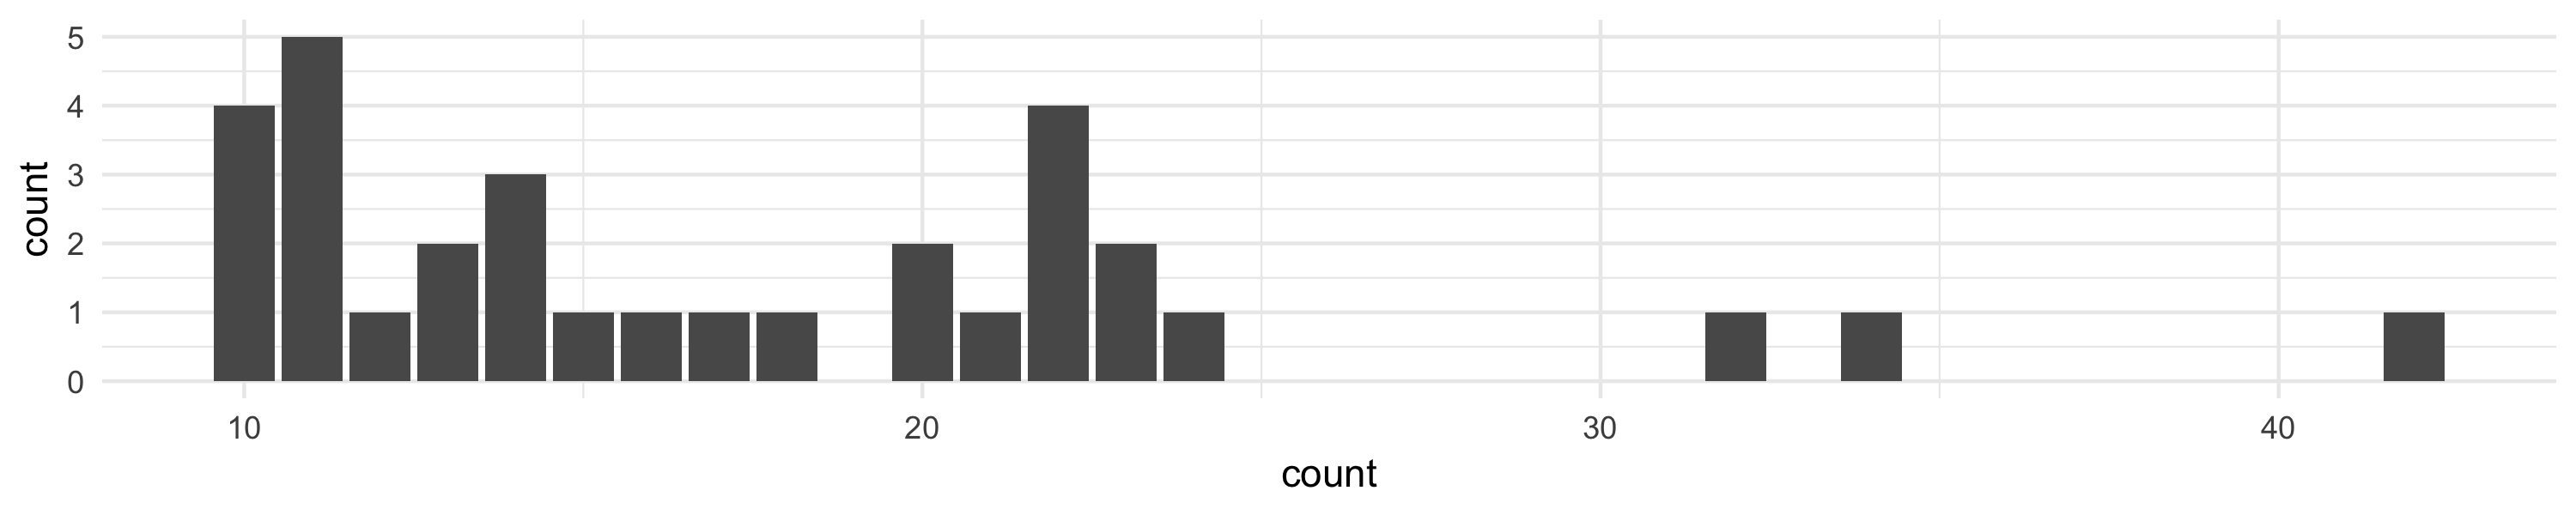

In [312]:
repeated_key <- mut_key_info[mut_key_info$count >= 2,] # keys shared by at least 2 samples
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(x = count)) + geom_vline(aes_(xintercept = 10), linetype = "dashed", color = "red")
ggplot(repeated_key[repeated_key$count >= 10,]) + geom_bar(aes(x = count))

### Sudy the reccurent mutations genes

In [313]:
length(unique(repeated_key$Hugo_Symbol))

[1] 448

In [314]:
head(repeated_key)

mut_key        count Hugo_Symbol
7  1_11169411_C_T 2     MTOR       
11 1_11169776_G_A 2     MTOR       
20 1_11181321_C_G 3     MTOR       
27 1_11182069_G_A 2     MTOR       
30 1_11182162_G_A 2     MTOR       
38 1_11184683_G_A 2     MTOR

Here is a plot of the genes that are the most mutated **accross the mutation keys**:

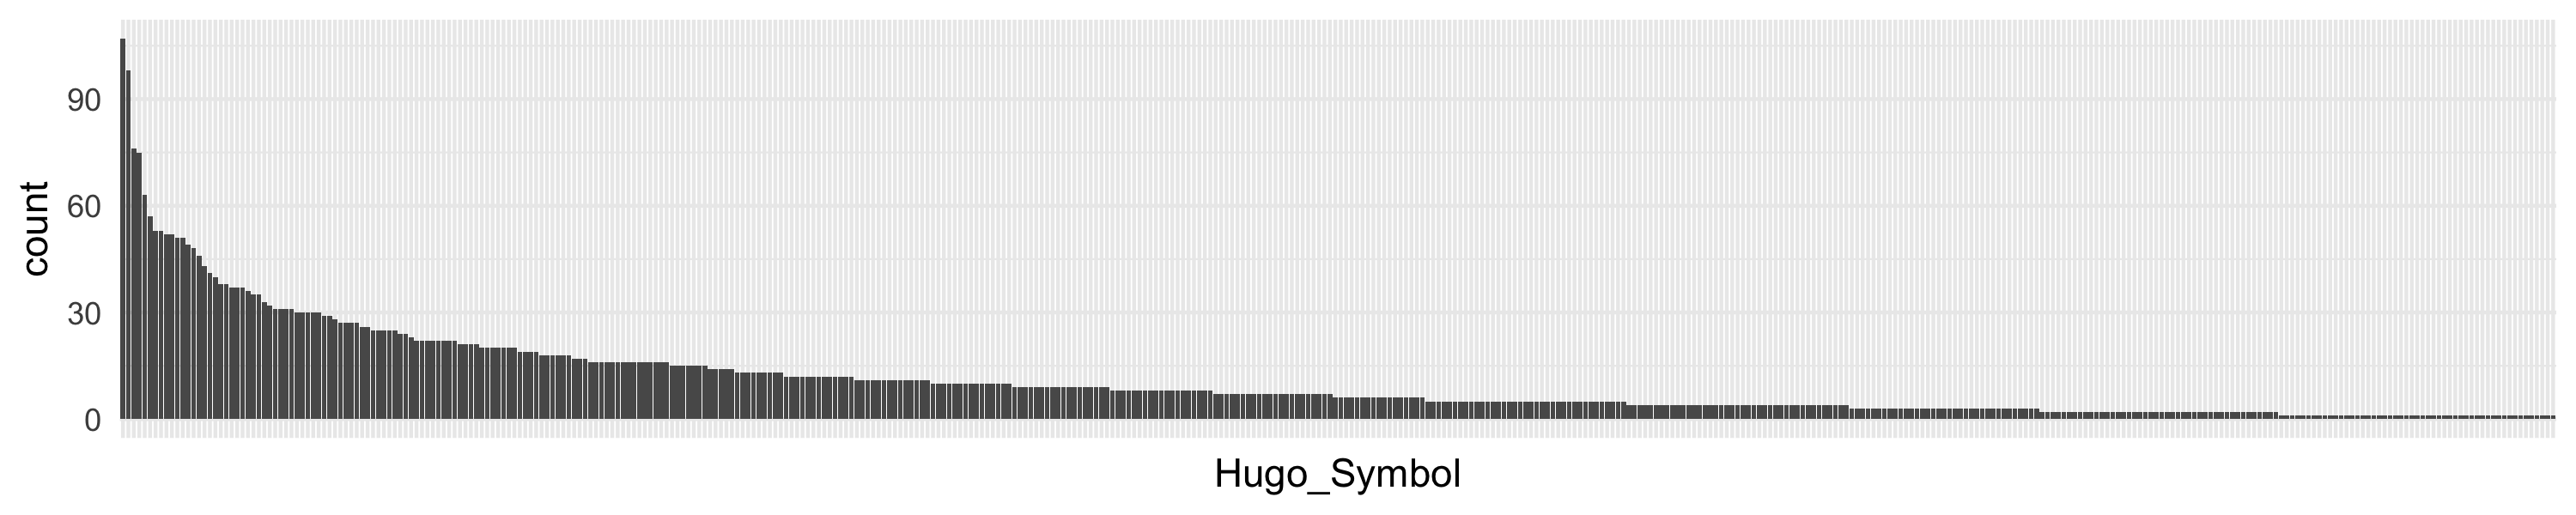

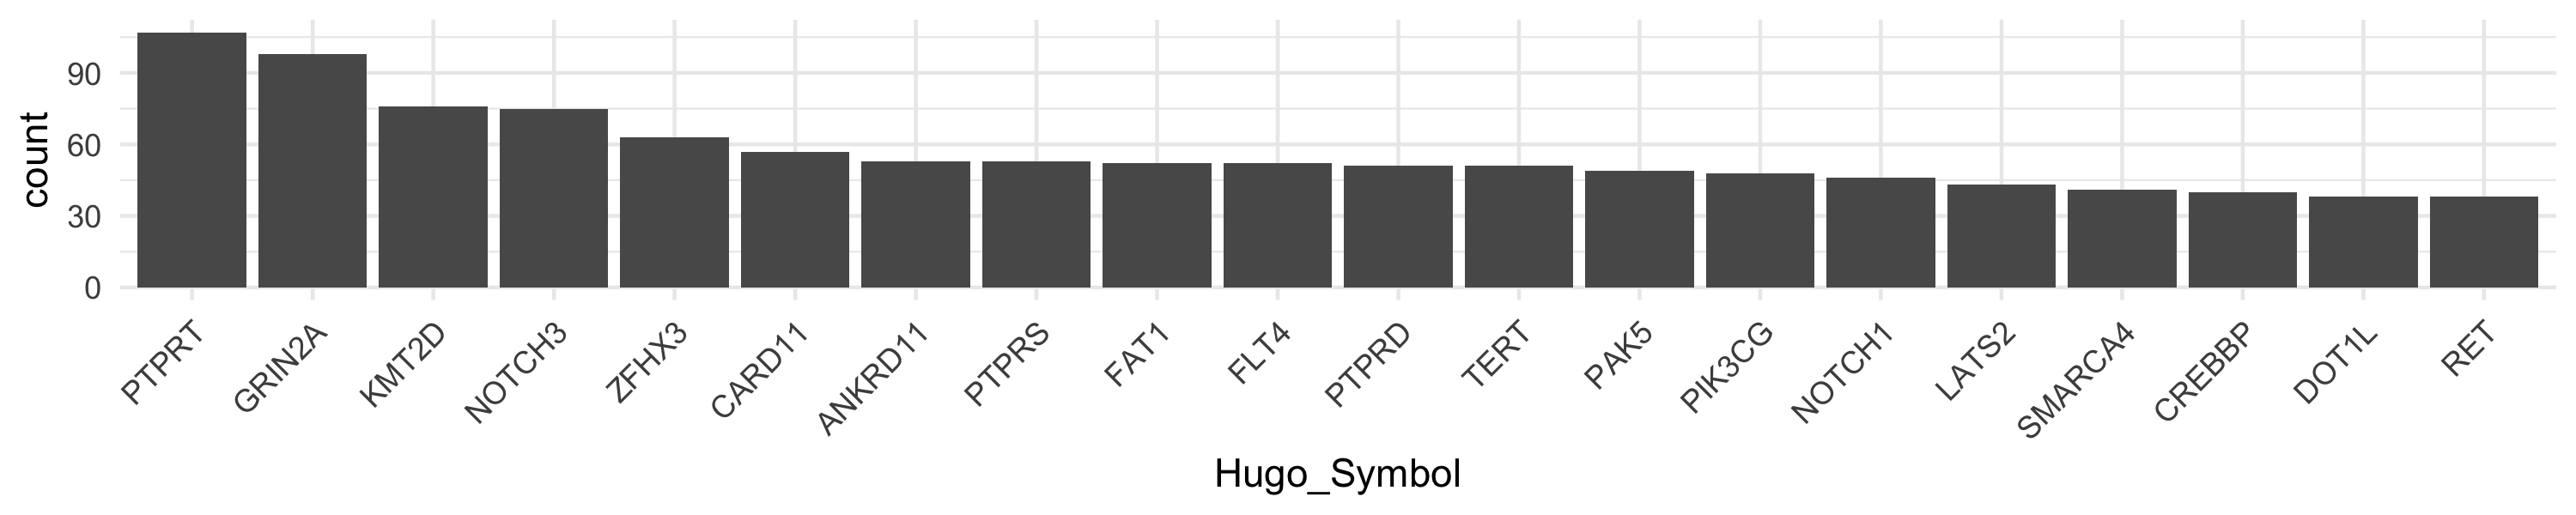

In [315]:
repeated_key <- sort_histogram(repeated_key, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(repeated_key) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(repeated_key, "Hugo_Symbol", 20) + tilt_x_label_45()

Here is a plot of the genes that are the most mutated **accross the rows**:

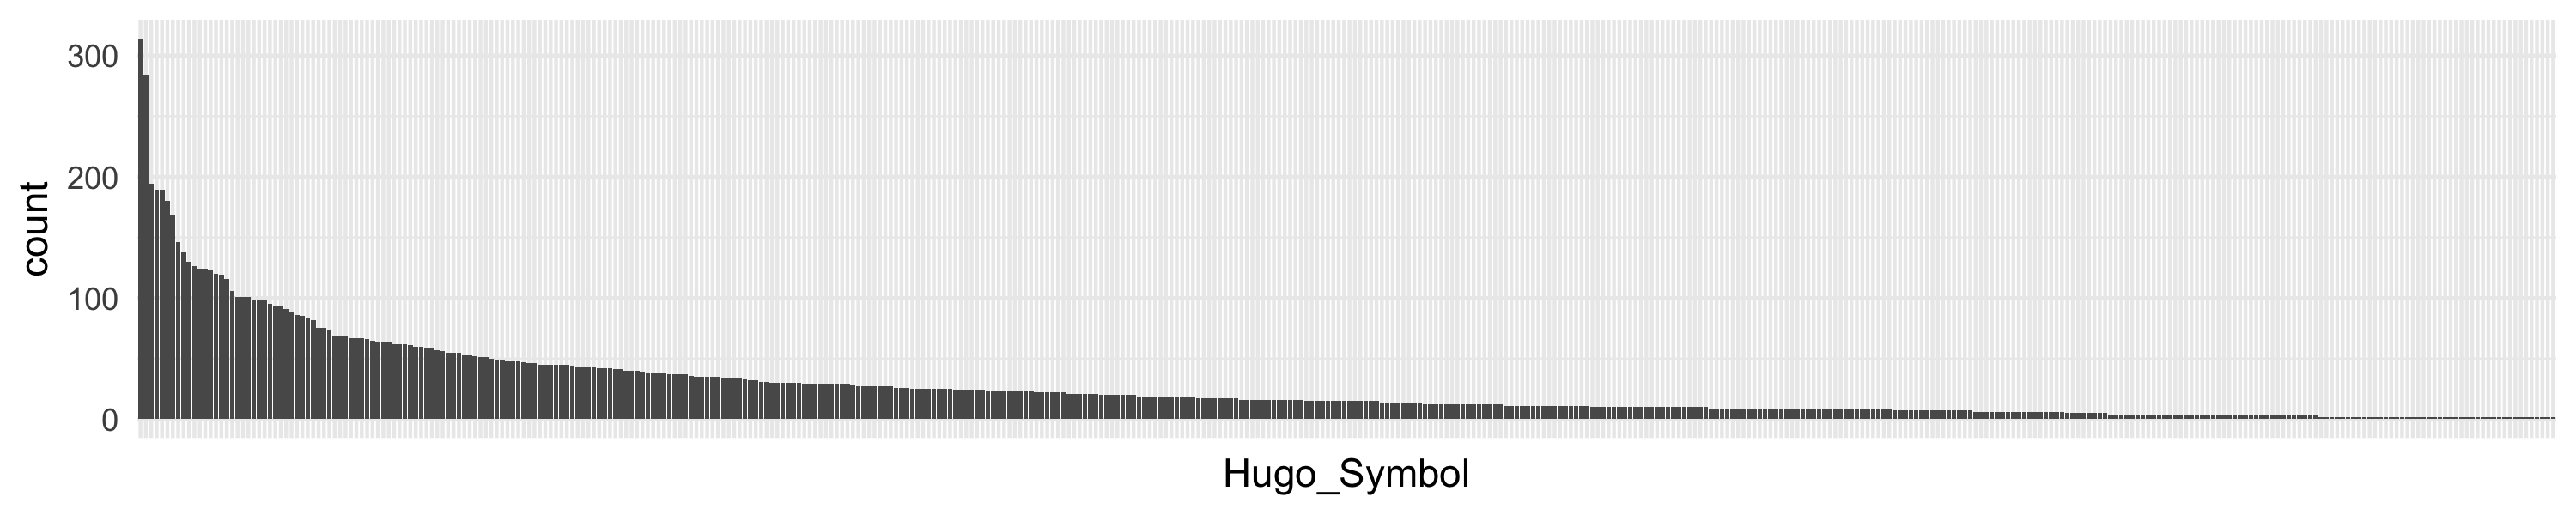

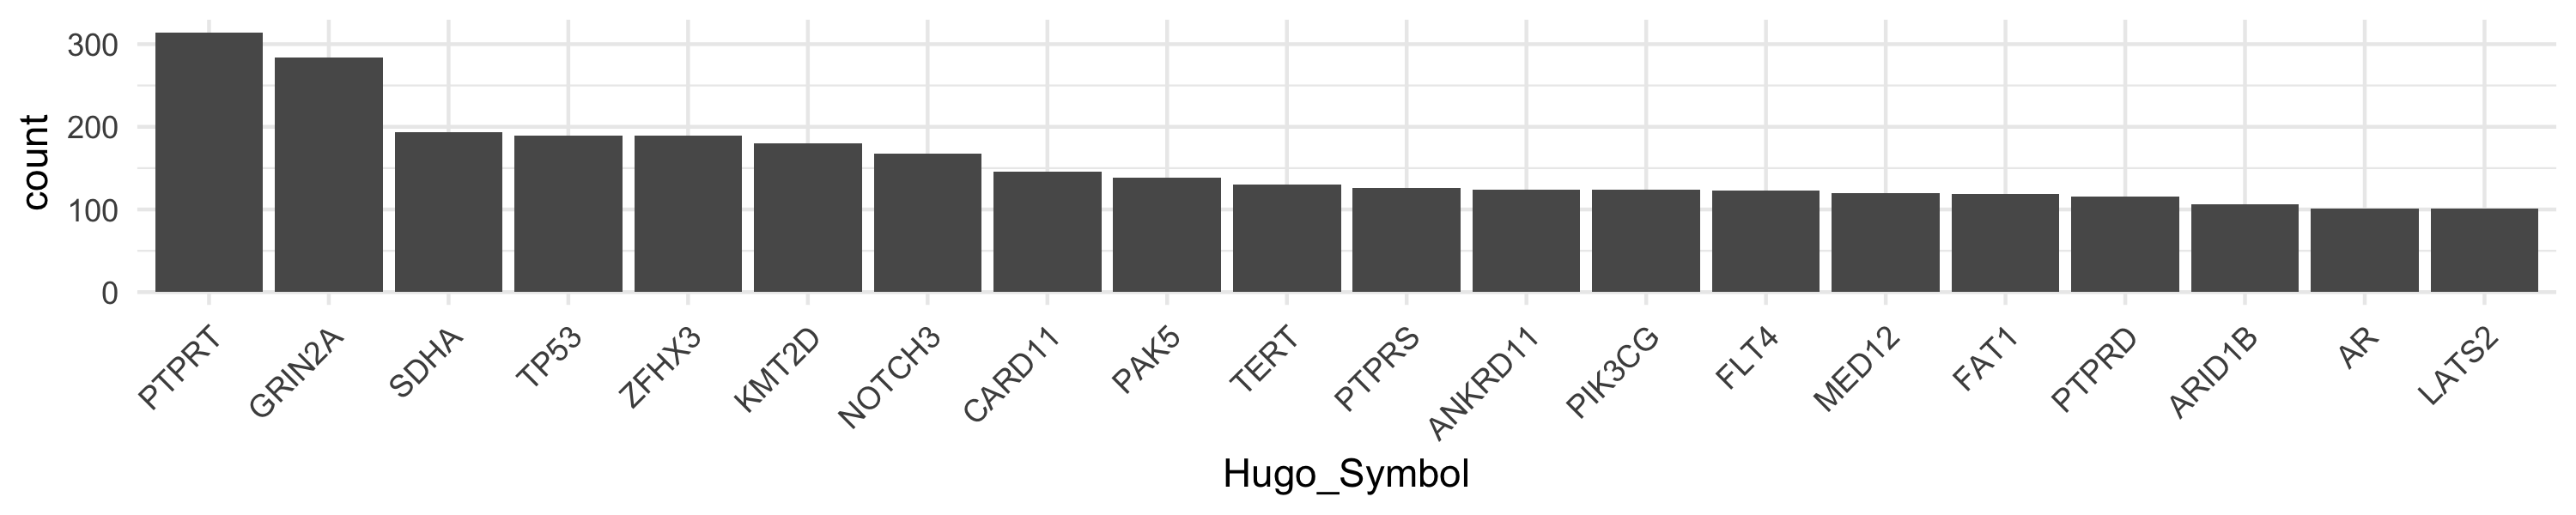

In [316]:
rec_impact <- impact_unique_mut_keys_per_patient[impact_unique_mut_keys_per_patient$mut_key %in% repeated_key$mut_key,]

rec_impact <- sort_histogram(rec_impact, "Hugo_Symbol")
notebook_plot_size(10, 2)
ggplot(rec_impact) + geom_bar(aes(Hugo_Symbol)) + theme(axis.text.x = element_blank())
plot_histogram_top(rec_impact, "Hugo_Symbol", 20) + tilt_x_label_45()

### Study the outliers

Let's study the outliers present in more than 20 samples:

In [317]:
outliers <- repeated_key %>% filter(count >= 20) %>%
                             arrange(-count) %>%
                             mutate(rank = row_number()) %>%
                             select(rank, count, mut_key, Hugo_Symbol)
        
outliers

rank count mut_key         Hugo_Symbol
1   1   42    X_66766359_C_T  AR         
2   2   34    17_7579312_C_T  TP53       
3   3   32    17_7579312_C_A  TP53       
4   4   24    5_235397_T_G    SDHA       
5   5   23    5_235403_C_G    SDHA       
6   6   23    5_235406_C_G    SDHA       
7   7   22    5_235400_C_T    SDHA       
8   8   22    5_235415_T_C    SDHA       
9   9   22    5_235418_T_C    SDHA       
10 10   22    X_76907799_T_C  ATRX       
11 11   21    5_235382_G_C    SDHA       
12 12   20    5_235379_C_G    SDHA       
13 13   20    6_157099426_A_G ARID1B

We will study in order:
* The rows 1 (AR), 10 (ATRX) and 13 (AR1D1B)
* The rows 2 and 3 (TP53)
* The remaining rows (SDHA)

See later for use of the following function:

In [318]:
get_mutation_info <- function(data, mutation_key, cosmic_and_gnomad = TRUE, plots = FALSE) {
    selected_rows <- data[data$mut_key == mutation_key,]
    
    mutation <- selected_rows %>% summarise(count = n(),
                                            mut_key = unique(mut_key),
                                            Hugo_Symbol = unique(Hugo_Symbol),
                                            Chromosome = unique(Chromosome),
                                            cDNA_change = toString(unique(cDNA_change)),
                                            HGVSp_Short = toString(unique(HGVSp_Short)),
                                            Kaviar_AF = unique(Kaviar_AF),
                                            cosmic_count = unique(cosmic_count))
    
    if (cosmic_and_gnomad) {
        print(paste0("gnomAD link: http://gnomad.broadinstitute.org/variant/",
                     gsub('_', '-', mutation_key), " "))
        print(paste0("COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=",
                     mutation$Hugo_Symbol, "+", mutation$HGVSp_Short, " "))
    }
    
    if (plots) {
        
        data$name <- "0_all dataset"
        data[data$mut_key == mutation_key,]$name <- mutation_key
    
        plot1 <- plot_density(data, "t_vaf", fill = "name", height = 2, adjust = 1/3) + theme(legend.position = "none")
        
        if (any(selected_rows$frequency_in_normals != 0)) {
            plot2 <- plot_density(data[data$frequency_in_normals != 0,], "frequency_in_normals", fill = "name", height = 2, adjust = 1/3)        }
        else
            plot2 <- ggplot() + annotate("text", x = 1, y = 1, label = "frequency_in_normals = 0") +
                                theme(text = element_blank())
        
        plot_side_by_side(plot1, plot2, height = 1.5)
    }
    
    return (mutation)
}

#### Row 1 (AR), 10 (ATRX) and 13 (AR1DB1)

** Row 1: AR (`X_66766359_C_T`)**

[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/X-66766359-C-T "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=AR+p.G457G "


count mut_key        Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF
1 42    X_66766359_C_T AR          X          c.1371C>T   p.G457G     0.0001682
  cosmic_count
1 0

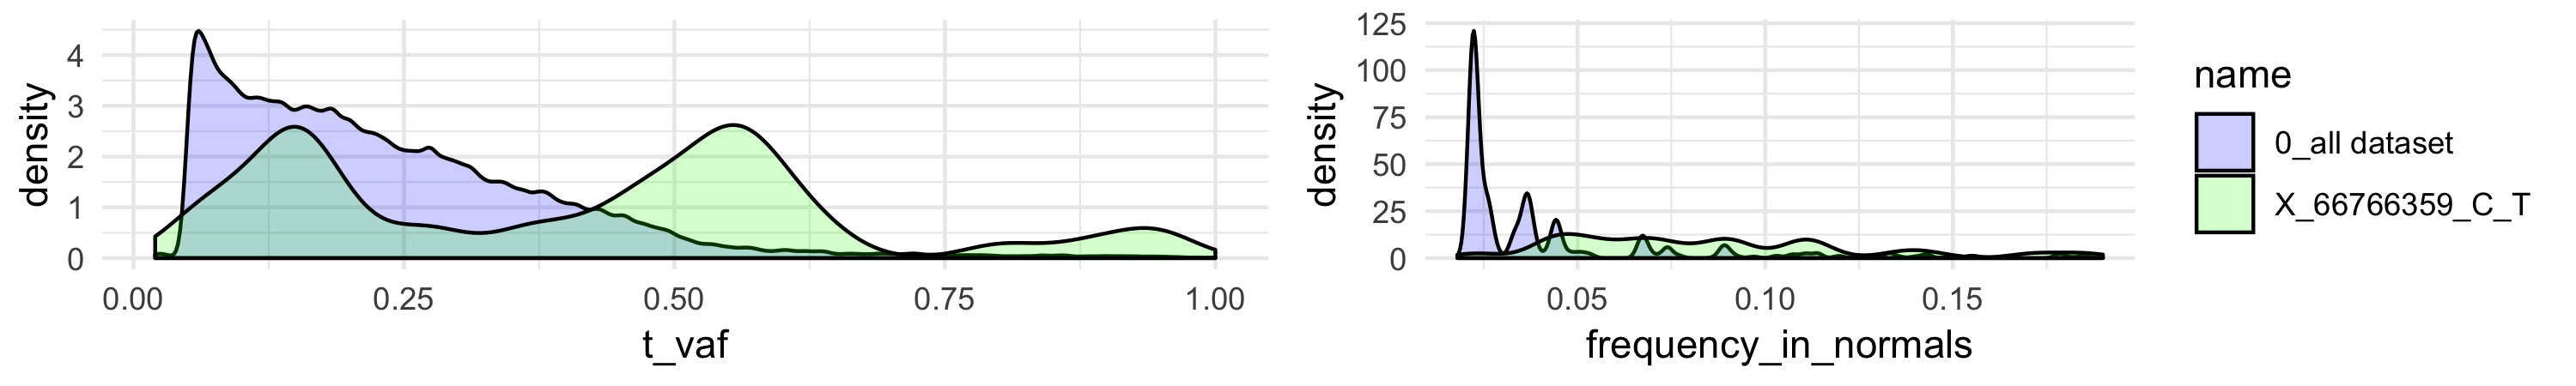

In [319]:
get_mutation_info(impact_syn, outliers$mut_key[1], plots = TRUE)

`t_vaf`$\approx$`0.5` and high `frequency_in_normals`, `Kaviar_AF` not null, and exists in gnomAD (allele frequency of 3.9%): probably germline.

** Row 10: ATRX (`X_76907799_T_C`) <font color='blue'> → further study needed </font>**

[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/X-76907799-T-C "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=ATRX+p.E1454E "


Warning message:
“Groups with fewer than two data points have been dropped.”

count mut_key        Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF
1 22    X_76907799_T_C ATRX        X          c.4362A>G   p.E1454E    0        
  cosmic_count
1 0

[1] "frequency_in_normals:"
 [1] 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000 0.000
[13] 0.000 0.000 0.000 0.000 0.000 0.037 0.000 0.000 0.000 0.000


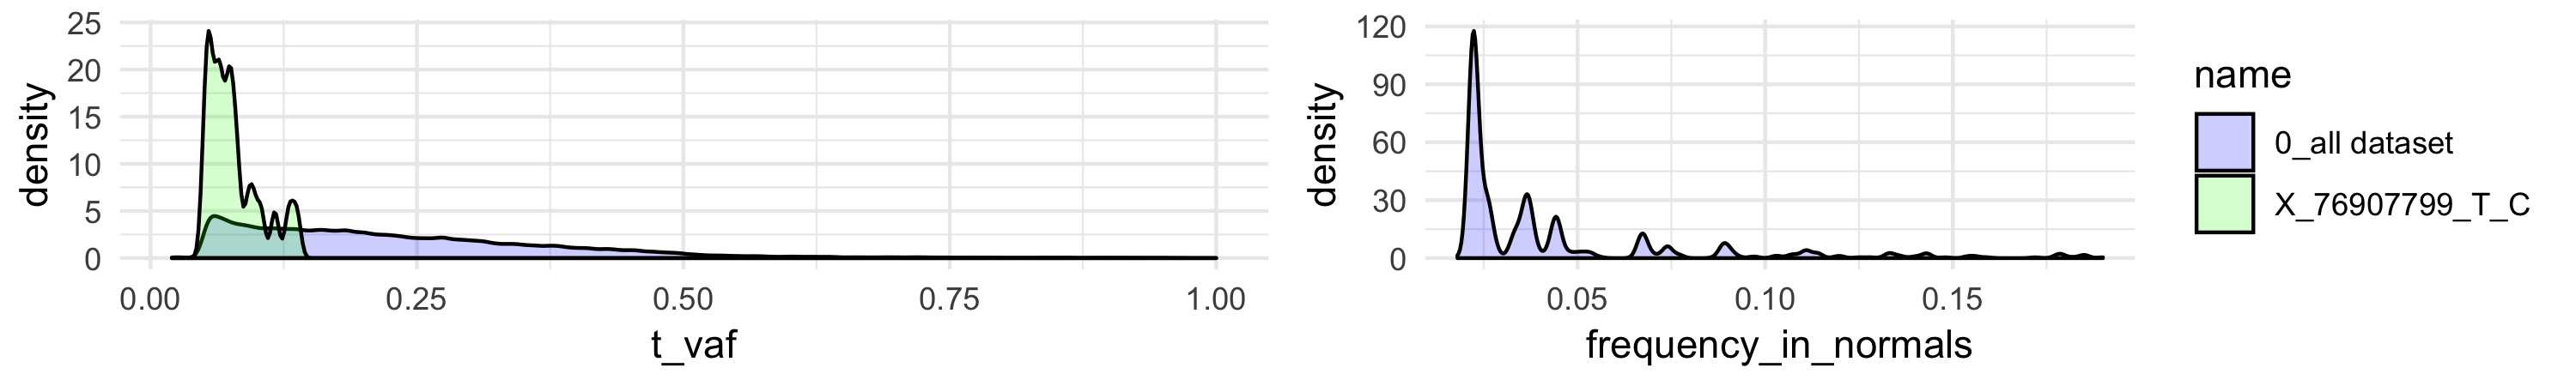

In [320]:
get_mutation_info(impact_syn, outliers$mut_key[10], plots = TRUE)
print("frequency_in_normals:")
print(impact_syn$frequency_in_normals[impact_syn$mut_key == outliers$mut_key[10]])

In [321]:
summary(impact$strand_ratio[impact$mut_key == outliers$mut_key[10]])

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
 0.3333  0.5000  0.6863  0.6744  0.8333  1.0000 

Not in COSMIC nor in gnomAD.

**Row 13: AR1DB1 (`6_157099426_A_G`)**

[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/6-157099426-A-G "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=ARID1B+p.Q121Q "


count mut_key         Hugo_Symbol Chromosome cDNA_change HGVSp_Short
1 20    6_157099426_A_G ARID1B      6          c.363A>G    p.Q121Q    
  Kaviar_AF cosmic_count
1 0.0004657 0

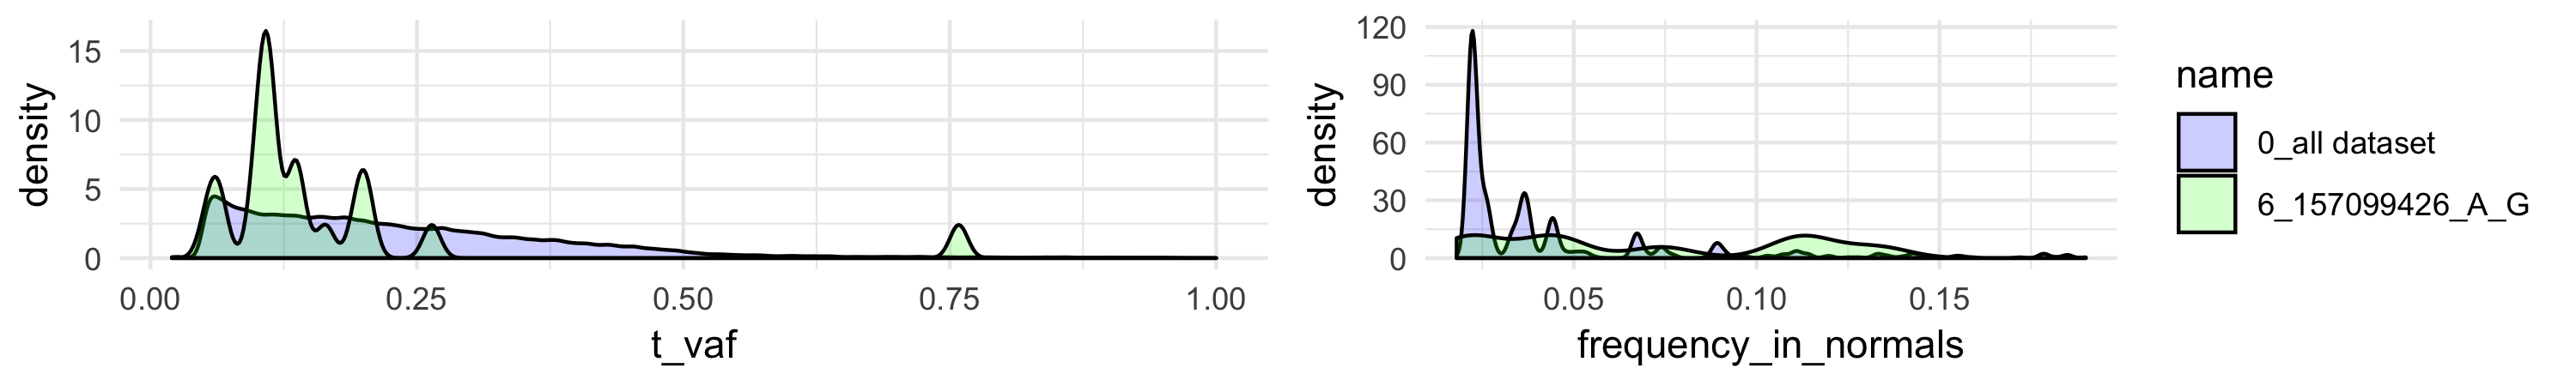

In [322]:
get_mutation_info(impact_syn, outliers$mut_key[13], plots = TRUE)

High `frequency_in_normals`, `Kaviar_AF` not null, and exists in gnomAD (allele frequency of 0.4%): probably germline.

#### Rows 2 and 3 (TP53)  <font color='blue'> → further study needed </font>

* These two synonymous mutations are acting on the same 3-bp
* The `HGVSp_Short` concerned is `p.T125T`
* They concern 66 different patients
* They both exist in COSMIC
* The both have a null gnomAD and `frequency_in_normals`
* The third variant (`c.375G>C`) appears 5 times in the database

In [323]:
length(unique(impact_syn$patient_id[impact_syn$mut_key %in% outliers$mut_key[outliers$Hugo_Symbol == "TP53"]]))

[1] 66

[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/17-7579312-C-T "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=TP53+p.T125T "


count mut_key        Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF
1 36    17_7579312_C_T TP53        17         c.375G>A    p.T125T     6.5e-06  
  cosmic_count
1 18

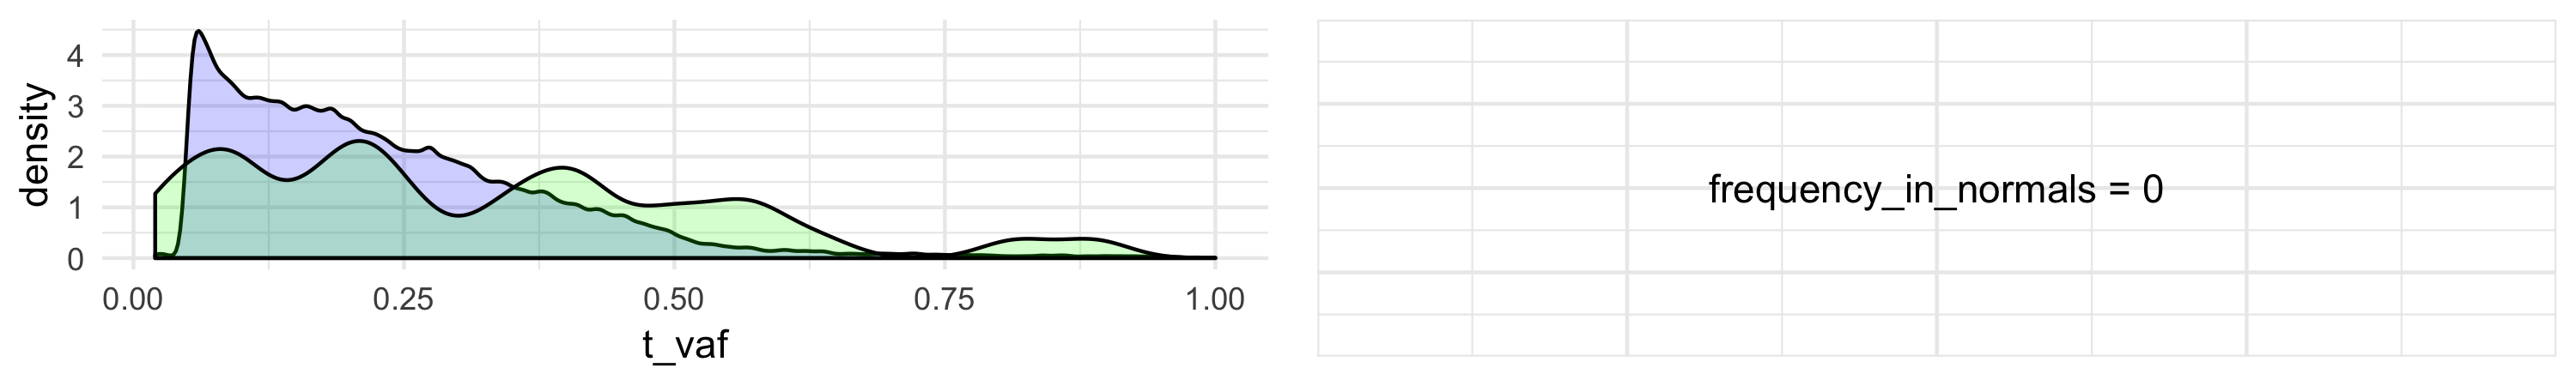

In [324]:
get_mutation_info(impact_syn, outliers$mut_key[2], plots = TRUE)

[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/17-7579312-C-A "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=TP53+p.T125T "


count mut_key        Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF
1 35    17_7579312_C_A TP53        17         c.375G>T    p.T125T     6.5e-06  
  cosmic_count
1 17

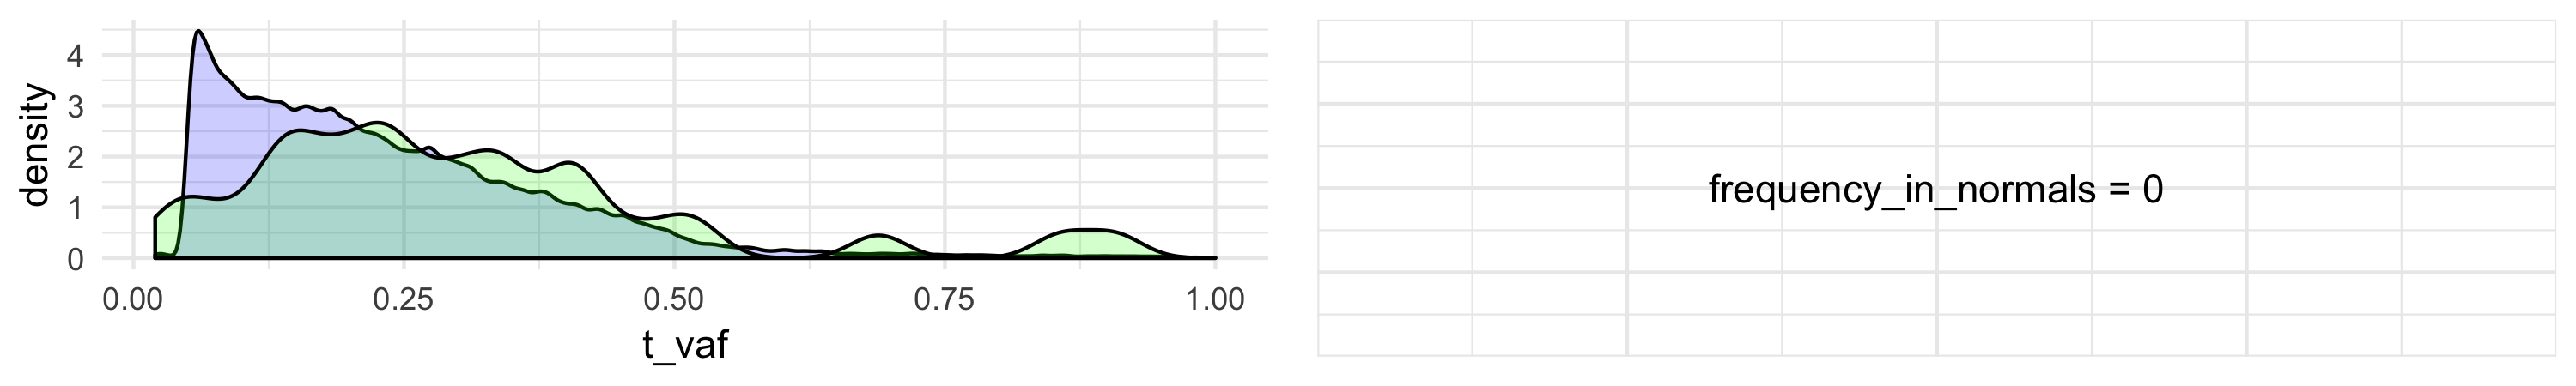

In [325]:
get_mutation_info(impact_syn, outliers$mut_key[3], plots = TRUE)

In [326]:
impact[impact$Hugo_Symbol == "TP53" & impact$cDNA_change == "c.375G>C",]

Hugo_Symbol Chromosome Start_Position End_Position Consequence   
75550  TP53        17         7579312        7579312      synonymous_SNV
97798  TP53        17         7579312        7579312      synonymous_SNV
109648 TP53        17         7579312        7579312      synonymous_SNV
138433 TP53        17         7579312        7579312      synonymous_SNV
202870 TP53        17         7579312        7579312      synonymous_SNV
       Variant_Type Reference_Allele Tumor_Seq_Allele2 Tumor_Sample_Barcode
75550  SNP          C                G                 P-0009867-T01-IM5   
97798  SNP          C                G                 P-0012717-T01-IM5   
109648 SNP          C                G                 P-0013977-T01-IM5   
138433 SNP          C                G                 P-0017157-T01-IM6   
202870 SNP          C                G                 P-0023859-T01-IM6   
       cDNA_change ⋯ t_alt_neg_count confidence_class sample_coverage
75550  c.375G>C    ⋯ 326             UNKNOWN          1130           
97798  c.375G>C    ⋯ 125             UNKNOWN           915           
109648 c.375G>C    ⋯  65             UNKNOWN           961           
138433 c.375G>C    ⋯  23             UNKNOWN           905           
202870 c.375G>C    ⋯  11             UNKNOWN           497           
       mut_key        sample_mut_key                   frequency_in_normals
75550  17_7579312_C_G P-0009867-T01-IM5_17_7579312_C_G 0                   
97798  17_7579312_C_G P-0012717-T01-IM5_17_7579312_C_G 0                   
109648 17_7579312_C_G P-0013977-T01-IM5_17_7579312_C_G 0                   
138433 17_7579312_C_G P-0017157-T01-IM6_17_7579312_C_G 0                   
202870 17_7579312_C_G P-0023859-T01-IM6_17_7579312_C_G 0                   
       Kaviar_AF cosmic_count label      strand_ratio
75550  0         4            synonymous 0.7931873   
97798  0         4            synonymous 0.7022472   
109648 0         4            synonymous 0.6565657   
138433 0         4            synonymous 0.8518519   
202870 0         4            synonymous 0.5000000

#### Outliers in `SDHA`  <font color='blue'> → further study needed </font>

* These 8 synonymous mutations are acting on the same domain (`p.V395V`, `p.T396T`, `p.P401P`, `p.V402V`, `p.L403L`, `p.P404P`, `p.H407H`, `p.Y408Y`)
* 2 of them appear in COSMIC with a low cosmic count:
    * https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.P404P cosmic count = 1
    * https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.T396T cosmic count = 2
* They all have a null gnomAD and `frequency_in_normals` (except for one, `5_235400_C_T` having a really low gnomAD score 0.000004061 and a low `frequency_in_normals`)
* They concern 24 different patients, almost all having each of the 8 mutations with a similar vaf (see plots under)

24 patients are concerned with these 8 high reccurences in `SDHA`:

In [327]:
patients_concerned <- unique(impact_syn$patient_id[impact_syn$mut_key %in% outliers$mut_key[outliers$Hugo_Symbol == "SDHA"]])
length(patients_concerned)
patients_concerned

[1] 24

[1] "P-0016594" "P-0016853" "P-0016922" "P-0016945" "P-0018570" "P-0018600"
 [7] "P-0018613" "P-0018627" "P-0018657" "P-0018659" "P-0018697" "P-0018696"
[13] "P-0018690" "P-0018693" "P-0018708" "P-0018709" "P-0018757" "P-0018794"
[19] "P-0018832" "P-0018833" "P-0018839" "P-0018845" "P-0018867" "P-0018900"

These patients do not have any other mutation in this gene (except 2 for 2 different patients):

In [328]:
impact$patient_id <- substr(impact$Tumor_Sample_Barcode, 1, 9)

impact[impact$patient_id %in% patients_concerned &
       impact$Hugo_Symbol == "SDHA" &
       ! impact$mut_key %in% outliers$mut_key[outliers$Hugo_Symbol == "SDHA"],]

Hugo_Symbol Chromosome Start_Position End_Position Consequence      
153156 SDHA        5          235367         235367       synonymous_SNV   
153280 SDHA        5          235339         235339       nonsynonymous_SNV
       Variant_Type Reference_Allele Tumor_Seq_Allele2 Tumor_Sample_Barcode
153156 SNP          T                G                 P-0018696-T01-IM6   
153280 SNP          G                T                 P-0018693-T01-IM6   
       cDNA_change ⋯ confidence_class sample_coverage mut_key     
153156 c.1173T>G   ⋯ UNKNOWN           88             5_235367_T_G
153280 c.1145G>T   ⋯ AUTO_OK          346             5_235339_G_T
       sample_mut_key                 frequency_in_normals Kaviar_AF
153156 P-0018696-T01-IM6_5_235367_T_G 0                    0        
153280 P-0018693-T01-IM6_5_235339_G_T 0                    0        
       cosmic_count label          strand_ratio patient_id
153156 0            synonymous     0.4444444    P-0018696 
153280 0            coding_somatic 0.7931034    P-0018693

In [329]:
dd <- data.frame()

for (id in outliers$rank[outliers$Hugo_Symbol == "SDHA"])
    dd <- rbind(dd, get_mutation_info(impact, outliers$mut_key[outliers$rank == id], cosmic_and_gnomad = FALSE,
                                      plots = FALSE))
dd

count mut_key      Hugo_Symbol Chromosome cDNA_change HGVSp_Short Kaviar_AF
1 25    5_235397_T_G SDHA        5          c.1203T>G   p.P401P     0        
2 24    5_235403_C_G SDHA        5          c.1209C>G   p.L403L     0        
3 24    5_235406_C_G SDHA        5          c.1212C>G   p.P404P     0        
4 23    5_235400_C_T SDHA        5          c.1206C>T   p.V402V     0        
5 23    5_235415_T_C SDHA        5          c.1221T>C   p.H407H     0        
6 23    5_235418_T_C SDHA        5          c.1224T>C   p.Y408Y     0        
7 22    5_235382_G_C SDHA        5          c.1188G>C   p.T396T     0        
8 21    5_235379_C_G SDHA        5          c.1185C>G   p.V395V     0        
  cosmic_count
1 0           
2 0           
3 0           
4 0           
5 0           
6 0           
7 0           
8 0

In [330]:
for (id in outliers$rank[outliers$Hugo_Symbol == "SDHA"])
    get_mutation_info(impact, outliers$mut_key[outliers$rank == id], cosmic_and_gnomad = TRUE, plots = FALSE)

[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/5-235397-T-G "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.P401P "
[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/5-235403-C-G "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.L403L "
[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/5-235406-C-G "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.P404P "
[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/5-235400-C-T "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.V402V "
[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/5-235415-T-C "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.H407H "
[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/5-235418-T-C "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=SDHA+p.Y408Y "
[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/5-235382-G-C "
[1] "COSMIC link: ht

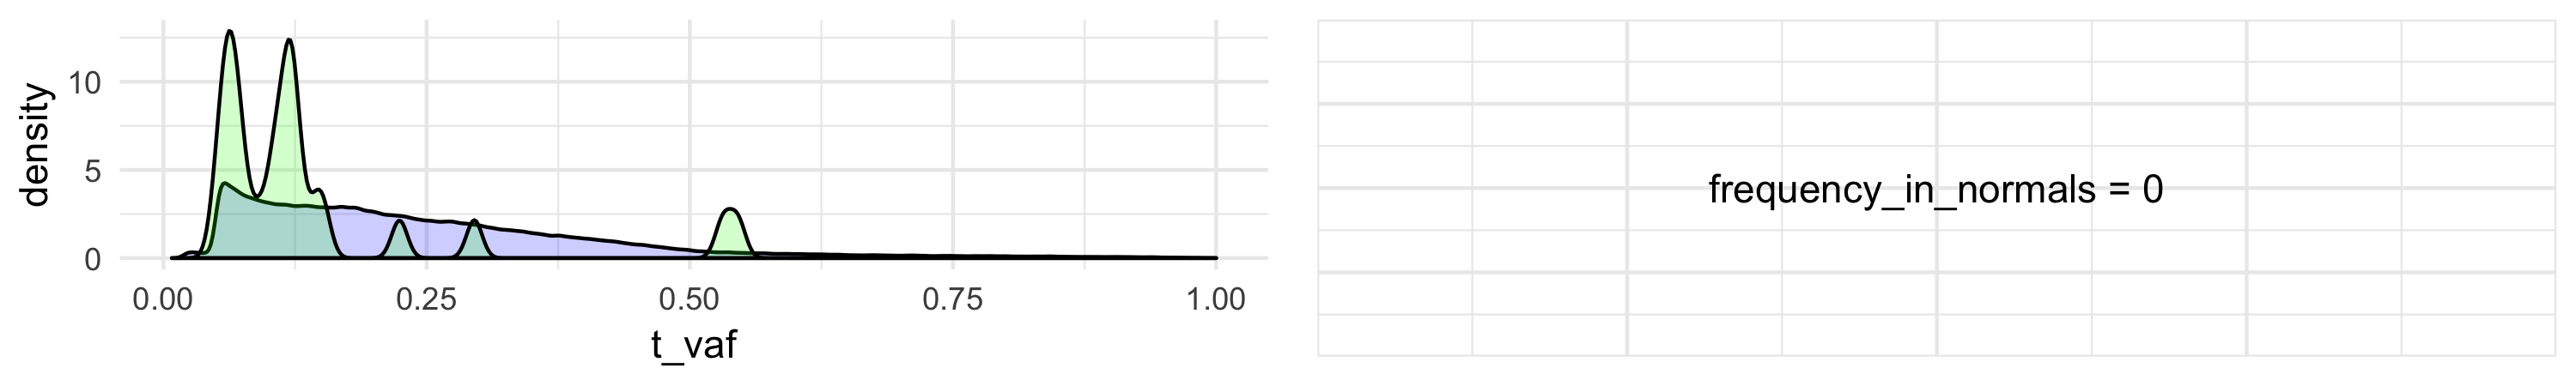

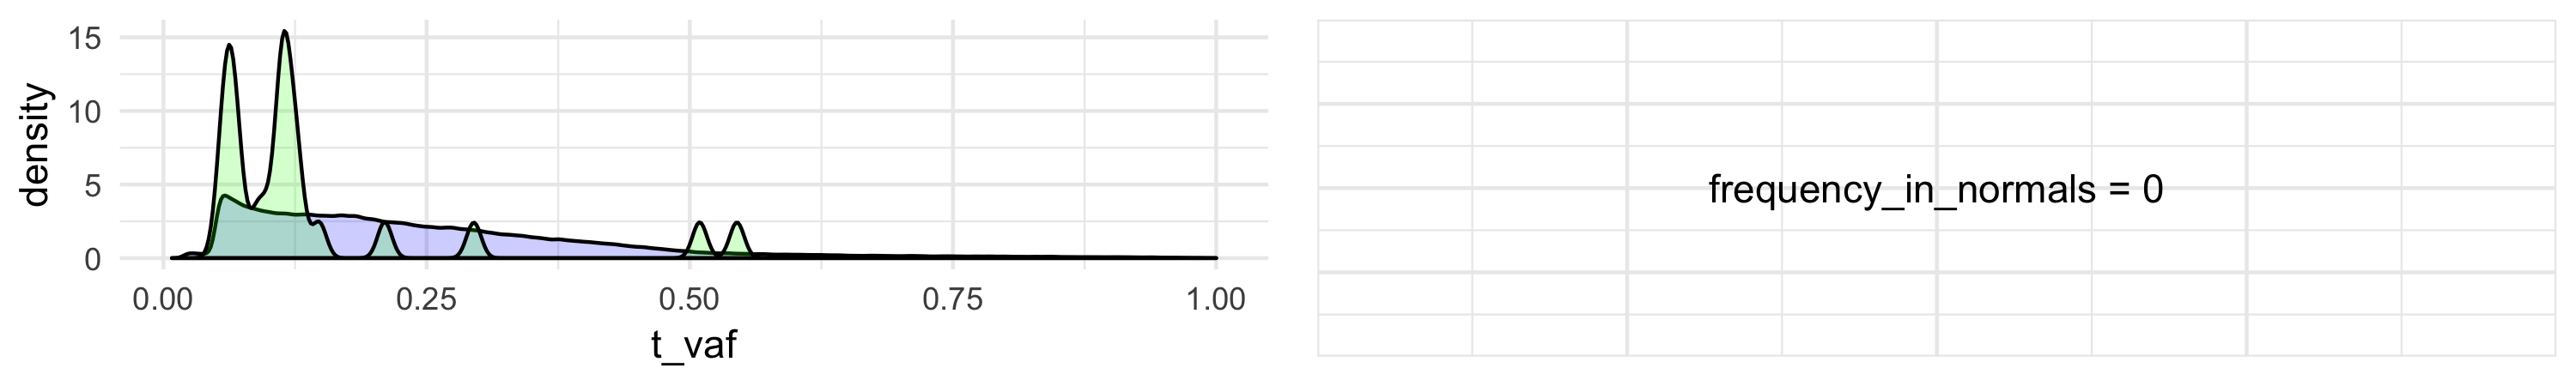

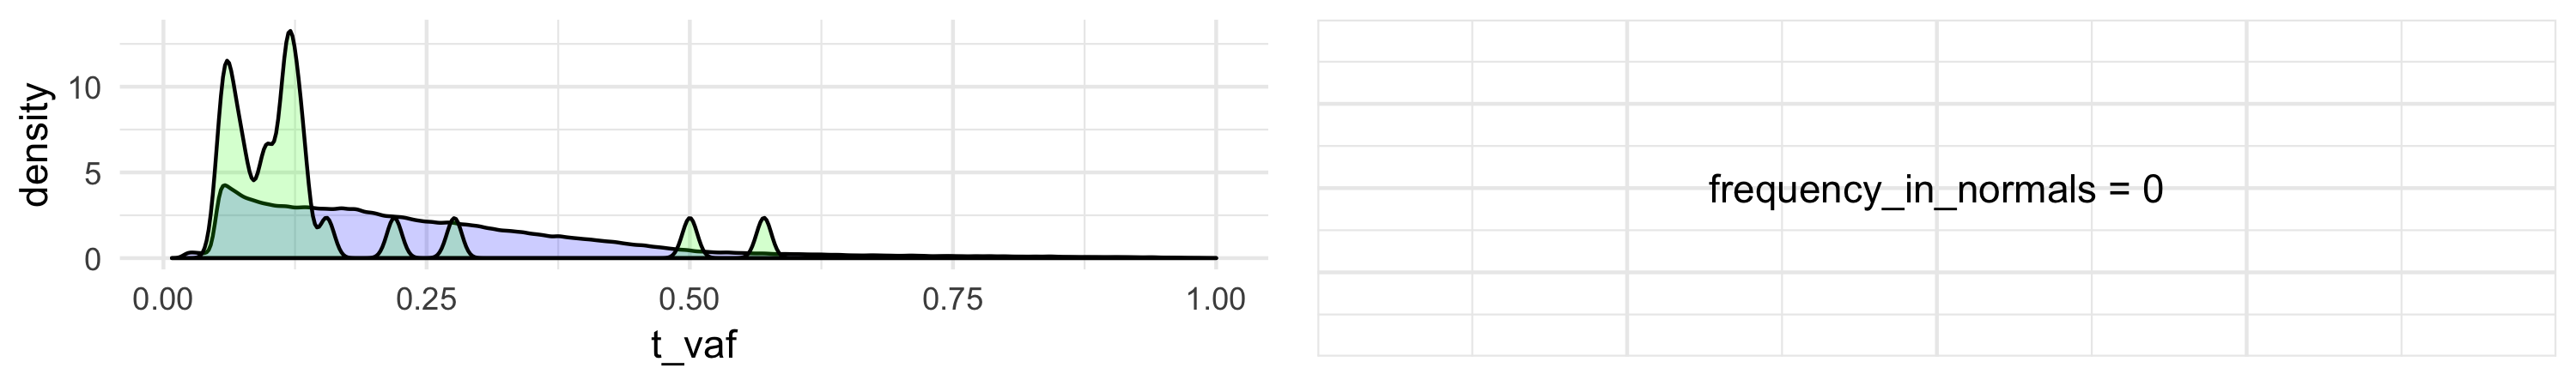

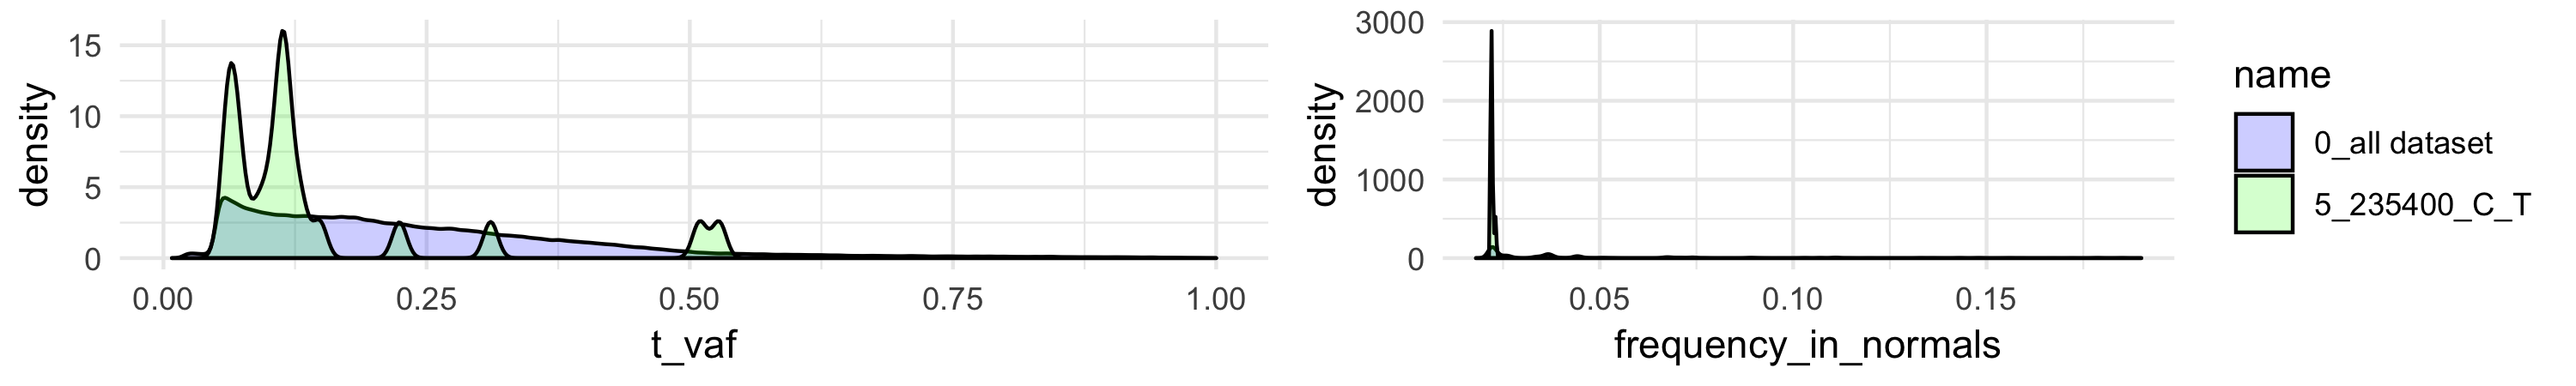

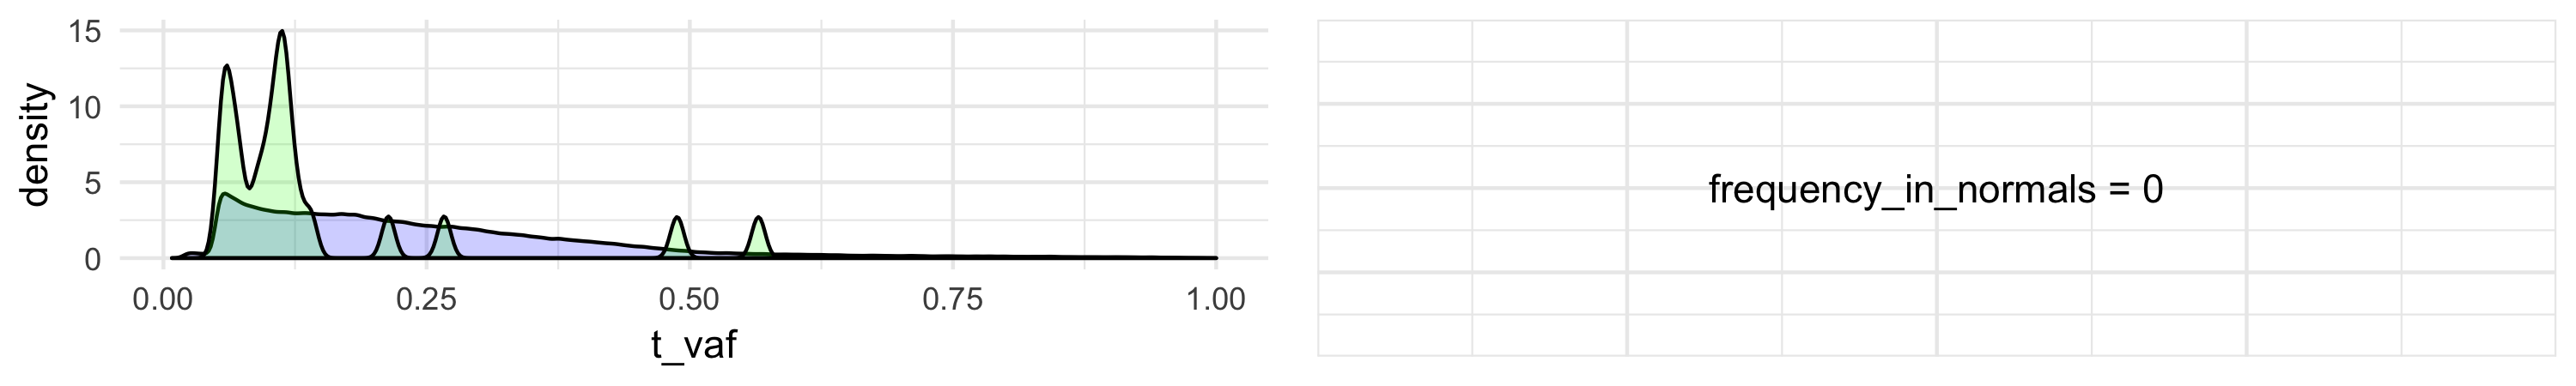

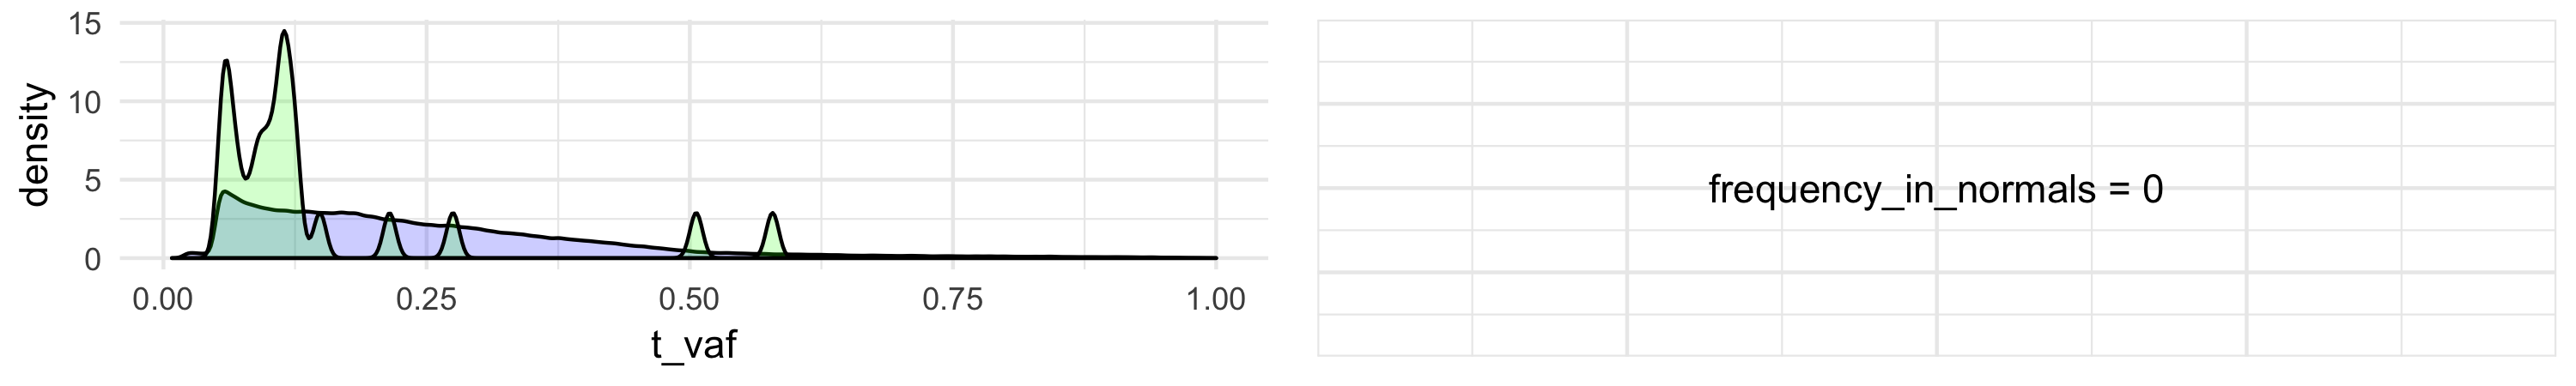

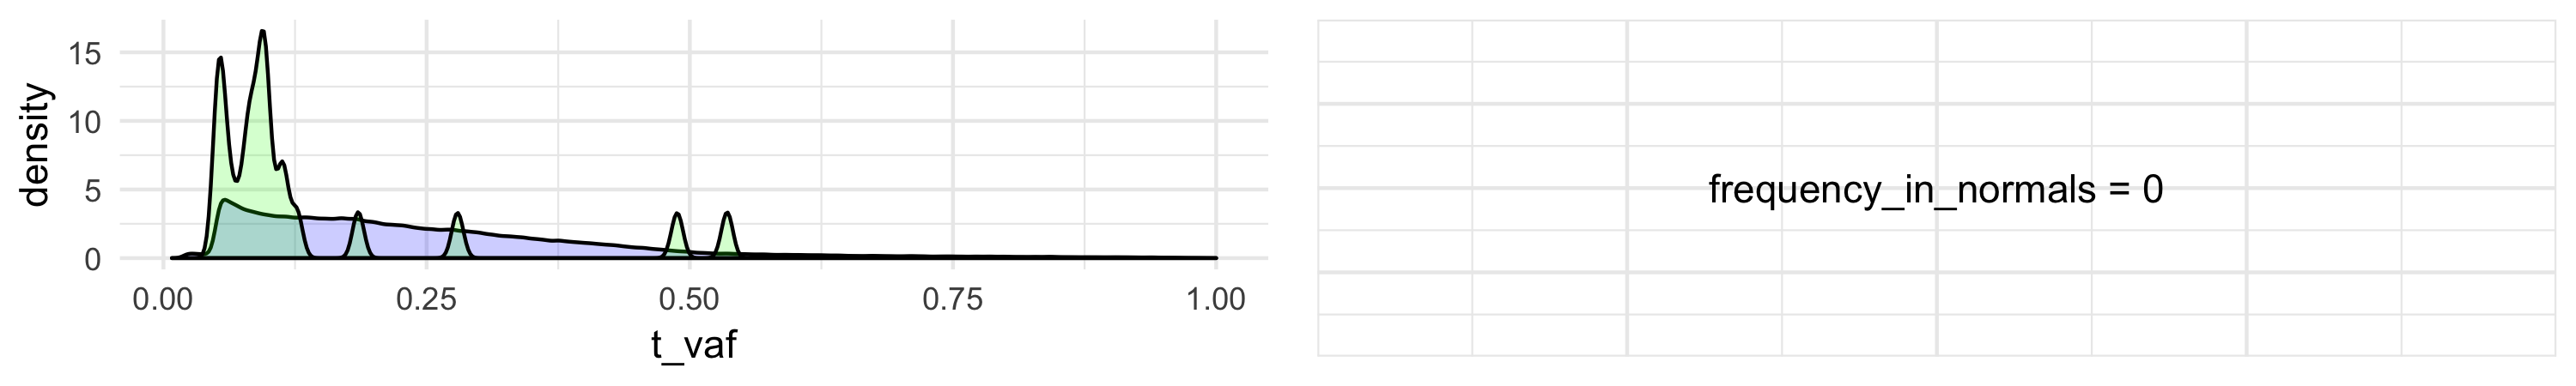

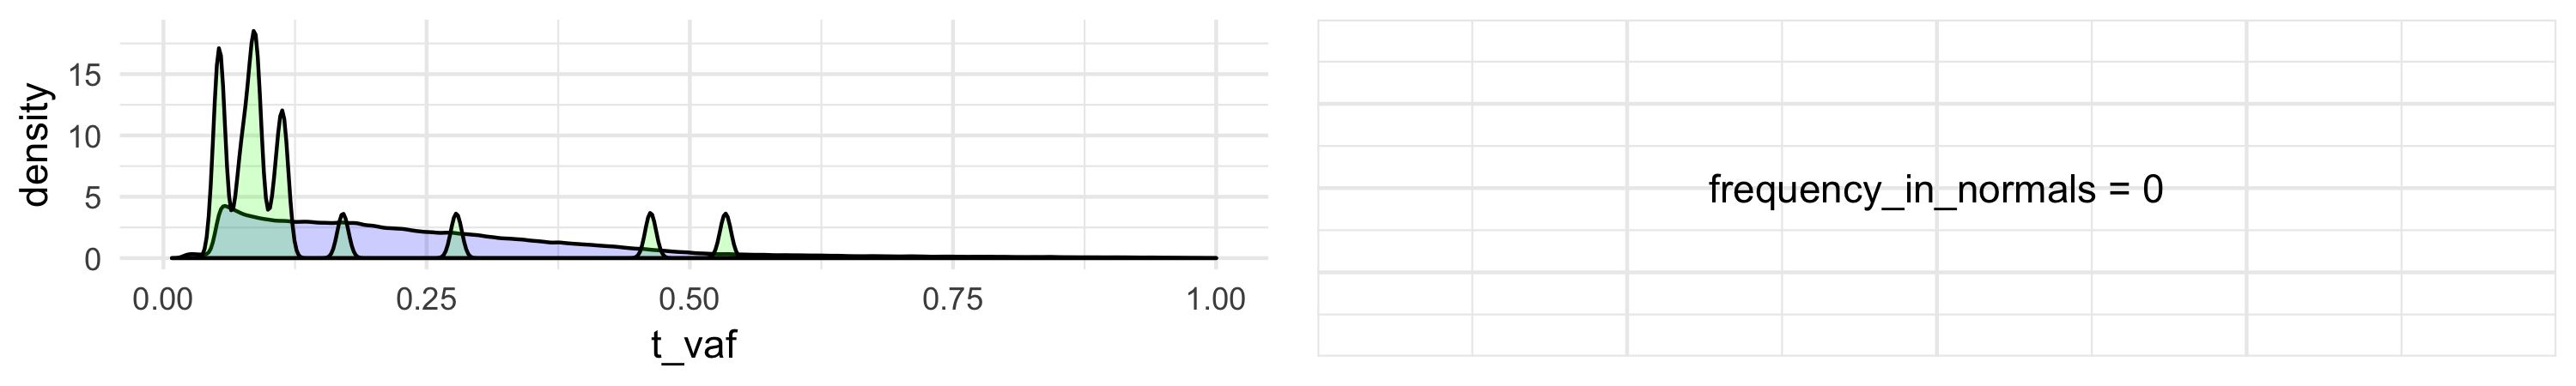

In [331]:
for (id in outliers$rank[outliers$Hugo_Symbol == "SDHA"])
    get_mutation_info(impact, outliers$mut_key[outliers$rank == id], cosmic_and_gnomad = FALSE, plots = TRUE)

In [332]:
get_simple_table(impact$Hugo_Symbol[impact$patient_id %in% patients_concerned], min = 5)

data
   SDHA    TP53  GRIN2A PIK3C2G     APC SMARCA4     Sum 
    187      12       7       6       6       5     223 

In [333]:
impact <- add_features("../../../data/", impact, oncokb = TRUE)

In [334]:
get_simple_table(impact$oncogenic[impact$patient_id %in% patients_concerned])

data
            Unknown    Likely Oncogenic           Oncogenic Predicted Oncogenic 
                459                  46                  14                   3 
     Likely Neutral        Inconclusive                 Sum 
                  1                   1                 524 

In [340]:
outliers <- repeated_key %>% filter(count >= 10 & count < 20) %>%
                             arrange(-count) %>%
                             mutate(rank = row_number()) %>%
                             select(rank, count, mut_key, Hugo_Symbol)
        
outliers

rank count mut_key          Hugo_Symbol
1   1   18    6_26056117_C_T   HIST1H1C   
2   2   17    X_70361115_G_A   MED12      
3   3   16    6_157100008_A_C  ARID1B     
4   4   15    X_70361103_G_A   MED12      
5   5   14    12_25380278_A_T  KRAS       
6   6   14    16_72821618_A_G  ZFHX3      
7   7   14    6_31324682_C_T   HLA-B      
8   8   13    16_72831388_C_T  ZFHX3      
9   9   13    20_41101171_G_A  PTPRT      
10 10   12    17_7574004_G_A   TP53       
11 11   11    12_102811752_C_T IGF1       
12 12   11    17_7578177_C_T   TP53       
13 13   11    18_60985834_C_T  BCL2       
14 14   11    20_40790142_C_T  PTPRT      
15 15   11    20_9525085_C_T   PAK5       
16 16   10    18_60985833_G_A  BCL2       
17 17   10    21_39795342_G_A  ERG        
18 18   10    6_20402595_C_T   E2F3       
19 19   10    6_30673105_C_G   MDC1

#### Next outliers

Let's study the outliers present between 10 and 20 samples:

In [341]:
outliers <- repeated_key %>% filter(count >= 10 & count < 20) %>%
                             arrange(-count) %>%
                             mutate(rank = row_number()) %>%
                             select(rank, count, mut_key, Hugo_Symbol)
        
outliers

rank count mut_key          Hugo_Symbol
1   1   18    6_26056117_C_T   HIST1H1C   
2   2   17    X_70361115_G_A   MED12      
3   3   16    6_157100008_A_C  ARID1B     
4   4   15    X_70361103_G_A   MED12      
5   5   14    12_25380278_A_T  KRAS       
6   6   14    16_72821618_A_G  ZFHX3      
7   7   14    6_31324682_C_T   HLA-B      
8   8   13    16_72831388_C_T  ZFHX3      
9   9   13    20_41101171_G_A  PTPRT      
10 10   12    17_7574004_G_A   TP53       
11 11   11    12_102811752_C_T IGF1       
12 12   11    17_7578177_C_T   TP53       
13 13   11    18_60985834_C_T  BCL2       
14 14   11    20_40790142_C_T  PTPRT      
15 15   11    20_9525085_C_T   PAK5       
16 16   10    18_60985833_G_A  BCL2       
17 17   10    21_39795342_G_A  ERG        
18 18   10    6_20402595_C_T   E2F3       
19 19   10    6_30673105_C_G   MDC1

We will study in order:
* The rows 1 (AR), 10 (ATRX) and 13 (AR1D1B)
* The rows 2 and 3 (TP53)
* The remaining rows (SDHA)

In [353]:
for (rank in seq(1, 3))
    get_mutation_info(impact_syn, outliers$mut_key[rank])

[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/6-26056117-C-T "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=HIST1H1C+p.A180A "
[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/X-70361115-G-A "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=MED12+p.Q2101Q "
[1] "gnomAD link: http://gnomad.broadinstitute.org/variant/6-157100008-A-C "
[1] "COSMIC link: https://cancer.sanger.ac.uk/cosmic/search?q=ARID1B+p.G315G "
